In [1]:
import cv2
import os
import numpy as np
from glob import glob
from pickle import dump
from matplotlib import pyplot as plt
from skimage.exposure import match_histograms

Load test images

In [2]:
test_images = []

for img in sorted(os.listdir('./data'), key=lambda x: int(x.split('.')[0])):
    img = cv2.imread(f'./data/{img}', 0)
    test_images.append(img)

Load ground truth character images

In [3]:
province_alpha = ['B', 'C', 'E', 'N', 'P', 'S', 'U', 'W']
ground_truth_license = []
ground_truth_province = []
idx2label_license = []
idx2label_province = []
for img in glob('./fonts/*.png'):
    filename = img.split('/')[-1].split('\\')[-1][0]
    if filename == 'g': continue
    idx2label_license.append(filename)
    ground_truth_license.append(cv2.imread(img, 0))
    if idx2label_license[-1] in province_alpha:
        ground_truth_province.append(cv2.imread(img, 0))
        idx2label_province.append(idx2label_license[-1])

In [4]:
govt_logo = cv2.imread('./fonts/govt_logo.png', 0)
ground_truth_province.append(govt_logo)
idx2label_province.append('UNK')

In [14]:
with open('./metadata/ground_truth_license.pkl', 'wb') as f:
    dump(ground_truth_license, f)

with open('./metadata/idx2label_license.pkl', 'wb') as f:
    dump(idx2label_license, f)

with open('./metadata/ground_truth_province.pkl', 'wb') as f:
    dump(ground_truth_province, f)

with open('./metadata/idx2label_province.pkl', 'wb') as f:
    dump(idx2label_province, f)

Utility functions

In [5]:
def check_aspect_ratio(dim=None, contour=None, tolerance=0.25):
    if contour is not None:
        x, y, w, h = cv2.boundingRect(contour)
    if dim is not None:
        w, h = dim
    aspect_ratio = w / h
    # Allow 25% (is it too big?) tolerance.
    # 1.5 aspect ratio thiyena number plates input wenne na kiyala assume karamu neh naththan kela wenna puluwan🥲
    return abs(aspect_ratio - 5) / 5 < tolerance # or abs(aspect_ratio - 1.5) / 1.5 < tolerance

def power_transform(img, gamma=1.0):
    return np.array(255. * (img / 255.) ** gamma, dtype=np.uint8)

def contrast_stretch(img, r1, s1, r2, s2):
    def mapPixels(x):
        if x <= r1: return (s1 / r1) * x
        elif r1 < x <= r2: return (x - r1) * (s2 - s1) / (r2 - r1) + s1
        return (x - r2) * (255 - s2) / (255 - r2) + s2

    return np.array([[mapPixels(x) for x in row] for row in img], dtype=np.uint8).reshape(img.shape)

def fix_contour(contour):
    top_left, top_right, bottom_left, bottom_right = contour
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left
    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left
    min_height = min(top_right[1] - top_left[1], bottom_right[1] - bottom_left[1])
    max_height = max(top_right[1] - top_left[1], bottom_right[1] - bottom_left[1])
    min_width = min(bottom_right[0] - top_right[0], bottom_left[0] - top_left[0])
    max_width = max(bottom_right[0] - top_right[0], bottom_left[0] - top_left[0])
    if check_aspect_ratio(dim=(min_width, min_height)):
        if bottom_right[0] - top_right[0] < bottom_left[0] - top_left[0]:
            top_left = (top_right[0], top_right[1] - min_height)
            bottom_left = (bottom_right[0], bottom_right[1] - min_height)
        else:
            top_right = (top_left[0], top_left[1] + min_height)
            bottom_right = (bottom_left[0], bottom_left[1] + min_height)
    elif check_aspect_ratio(dim=(max_width, max_height)):
        if bottom_right[0] - top_right[0] < bottom_left[0] - top_left[0]:
            top_right = (top_left[0], top_left[1] + max_height)
            bottom_right = (bottom_left[0], bottom_left[1] + max_height)
        else:
            top_left = (top_right[0], top_right[1] - max_height)
            bottom_left = (bottom_right[0], bottom_right[1] - max_height)
    elif check_aspect_ratio(dim=(max_width, min_height)):
        if bottom_right[0] - top_right[0] < bottom_left[0] - top_left[0]:
            top_right = (top_left[0], top_left[1] + min_height)
            bottom_right = (bottom_left[0], bottom_left[1] + min_height)
        else:
            top_left = (top_right[0], top_right[1] - min_height)
            bottom_left = (bottom_right[0], bottom_right[1] - min_height)
    elif check_aspect_ratio(dim=(min_width, max_height)):
        if bottom_right[0] - top_right[0] < bottom_left[0] - top_left[0]:
            top_left = (top_right[0], top_right[1] - max_height)
            bottom_left = (bottom_right[0], bottom_right[1] - max_height)
        else:
            top_right = (top_left[0], top_left[1] + max_height)
            bottom_right = (bottom_left[0], bottom_left[1] + max_height)
    return np.array([top_right, top_left, bottom_left, bottom_right])

def find_rect_contour(contour):
    if len(contour) == 0:
        return None
   # TODO
    return contour

def normalize(arr, eps=1e-9):
    range = arr.max() - arr.min()
    amin = arr.min()
    return (arr-amin) * 255 / (range + eps)

def compare_images(img1, img2):
    img1 = normalize(img1)
    img2 = normalize(img2)
    img1 = cv2.resize(img1, img2.shape[::-1])
    diff = img1 - img2 
    zero_norm = np.linalg.norm(diff.ravel(), 0)
    return zero_norm

def brightness(img):
    if len(img.shape) == 3:
        return np.average(np.linalg.norm(img, axis=2)) / np.sqrt(3)
    else:
        return np.average(img)

## Image 0

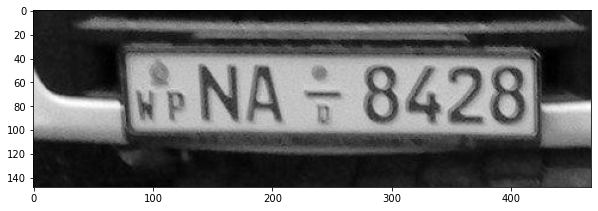

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(test_images[0], cmap='gray')

In [44]:
print(f'Brightness: {brightness(test_images[0])}')

Brightness: 88.82467082467082


Histogram equalization to improve contrast

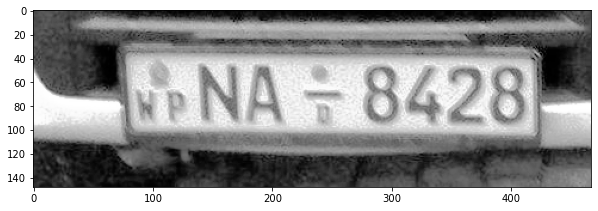

In [13]:
plt.figure(figsize=(10, 10))
equalized = cv2.equalizeHist(test_images[0])
plt.imshow(equalized, cmap='gray')

Remove noise

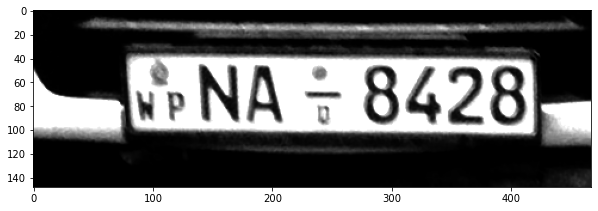

In [14]:
plt.figure(figsize=(10, 10))
denoised = cv2.bilateralFilter(equalized, 3, 75, 75)
denoised = contrast_stretch(denoised, 50, 10, 200, 255)
denoised = power_transform(denoised, 4)
plt.imshow(denoised, cmap='gray')

In [34]:
cv2.imwrite('./metadata/hist_ref.png', denoised)

True

Blackhat morphological transformation to enhance the text in the white background

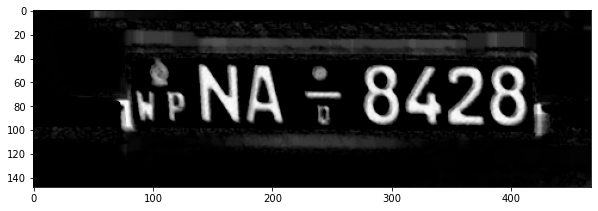

In [123]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
blackhat = cv2.morphologyEx(denoised, cv2.MORPH_BLACKHAT, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(blackhat, cmap='gray')

Thresholding to extract the text

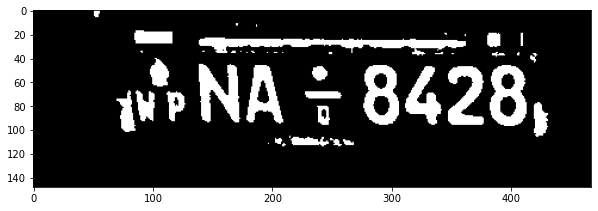

In [124]:
thresh = cv2.threshold(blackhat, 50, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10, 10))
plt.imshow(thresh, cmap='gray')

Number plate localization using morphological transformations (trying to separate license plate as a foreground object)

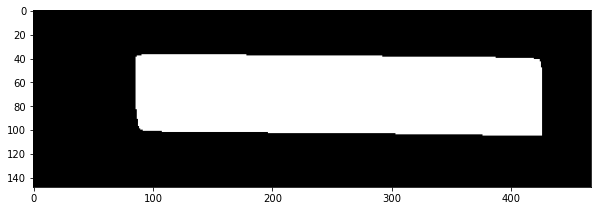

In [125]:
# Tophat transformation to enhance bright objects in dark background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 15))
tophat = cv2.morphologyEx(denoised, cv2.MORPH_TOPHAT, kernel)
# Thresholding the tophat result
top_thresh = cv2.threshold(tophat, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# Eroding the thresholded image to remove background noise
eroded = cv2.erode(top_thresh, kernel, iterations=3)
# Closing the gaps (removing false negatives) in between white pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 3))
top_closing = cv2.morphologyEx(eroded, cv2.MORPH_CLOSE, kernel, iterations=6)
# Remove noise (false positives) from foreground
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
top_opening = cv2.morphologyEx(top_closing, cv2.MORPH_OPEN, kernel, iterations=8)
# Dilating to expand the foreground closer to the original (expected) size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated = cv2.dilate(top_opening, kernel, iterations=2)
plt.figure(figsize=(10, 10))
plt.imshow(dilated, cmap='gray')

Drawing contours to separate out the license plate from the other foreground objects

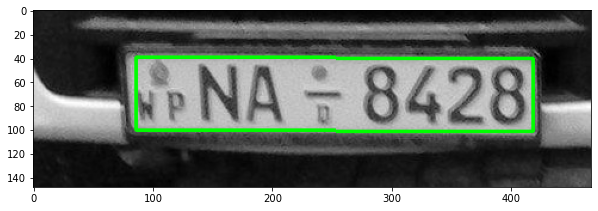

In [126]:
contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse = True)[:10]
plate_contour = None
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.06 * perimeter, True).reshape(-1, 2)
    if len(approx) == 4:
        if check_aspect_ratio(contour=approx):
            plate_contour = fix_contour(approx)
            break
    else:
        # Try to find a contour with 4 vertices that has a similar aspect ratio
        approx = find_rect_contour(approx)
        if check_aspect_ratio(contour=approx):
            plate_contour = approx
            break
test = test_images[0].copy()
test = cv2.cvtColor(test, cv2.COLOR_GRAY2BGR)
if plate_contour is not None:
    final = cv2.drawContours(test, [plate_contour], -1, (0, 255, 0), 2)
else:
    final = test
plt.figure(figsize=(10, 10))
plt.imshow(final)

Cropping the license plate using the found contour

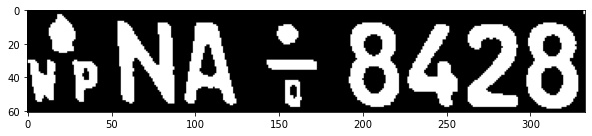

In [127]:
plate_contour = sorted(plate_contour, key=lambda x: x[0])
top_left, top_right, bottom_left, bottom_right = plate_contour
if top_left[1] > top_right[1]:
    top_left, top_right = top_right, top_left
if bottom_left[1] > bottom_right[1]:
    bottom_left, bottom_right = bottom_right, bottom_left
height = max(top_right[1] - top_left[1], bottom_right[1] - bottom_left[1])
width = max(bottom_right[0] - top_right[0], bottom_left[0] - top_left[0])
cropped = thresh[top_left[1]:top_left[1] + height, top_left[0]:top_left[0] + width]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
cropped = cv2.morphologyEx(cropped, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(cropped, cmap='gray')

In [128]:
(num_labels, labels, stats, centroids) = cv2.connectedComponentsWithStats(cropped, 4, cv2.CV_32S)
print(f'Found {num_labels} connected components')

Found 14 connected components


Segmenting the license plate number into characters

Average area: 492.3076923076923


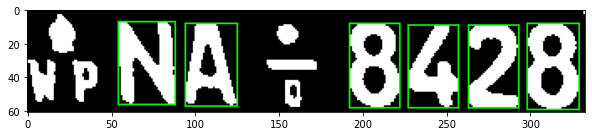

In [129]:
output = cropped.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

avg_area = stats[1:, cv2.CC_STAT_AREA].mean()
print(f'Average area: {avg_area}')

num_candidates = []

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    # Iterating the LOWER BOUND until four characters are found might be a better approach
    if avg_area * 3 > area > avg_area * 0.6 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        num_candidates.append((cropped[y:y + h, x:x + w], x))
num_candidates = sorted(num_candidates, key=lambda x: x[1])
num_candidates = [x[0] for x in num_candidates]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [130]:
for candidate in num_candidates:
    res = []
    for img in ground_truth_license:
        res.append(compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_license[res.argmin()])

N
A
8
4
2
8


Segmenting the province into characters

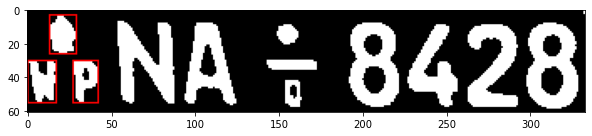

In [131]:
output = cropped.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

province_candidates = []

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area / 2.5 < area < avg_area / 1.2 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
        province_candidates.append((cropped[y:y + h, x:x + w], x))
province_candidates = sorted(province_candidates, key=lambda x: x[1])
province_candidates = [x[0] for x in province_candidates]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [160]:
for candidate in province_candidates:
    res = []
    for img, label in zip(ground_truth_province, idx2label_province):
        res.append(cv2.minMaxLoc(cv2.matchTemplate(img, candidate, cv2.TM_SQDIFF))[0]+ 6000 * compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_province[res.argmin()])

N
UNK
P


## Image 1

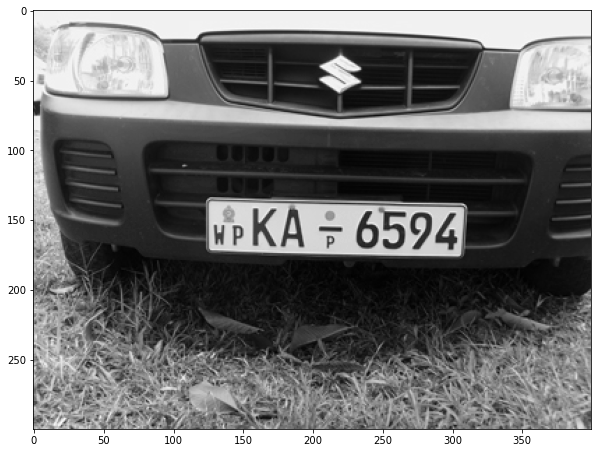

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(test_images[1], cmap='gray')

In [45]:
print(f'Brightness: {brightness(test_images[1])}')

Brightness: 103.87313333333333


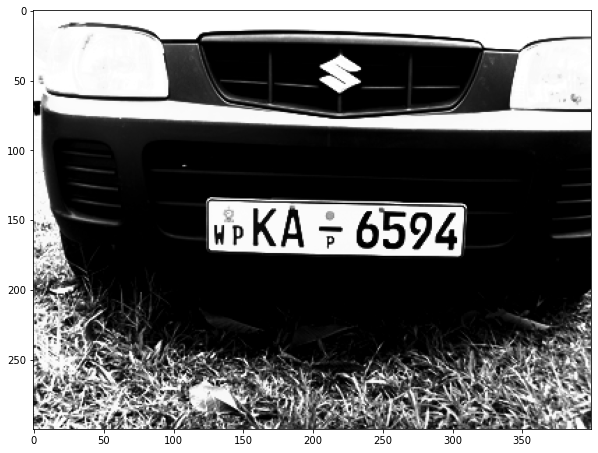

In [33]:
matched = match_histograms(test_images[1], denoised)
plt.figure(figsize=(10, 10))
plt.imshow(matched, cmap='gray')

Histogram equalization to improve contrast

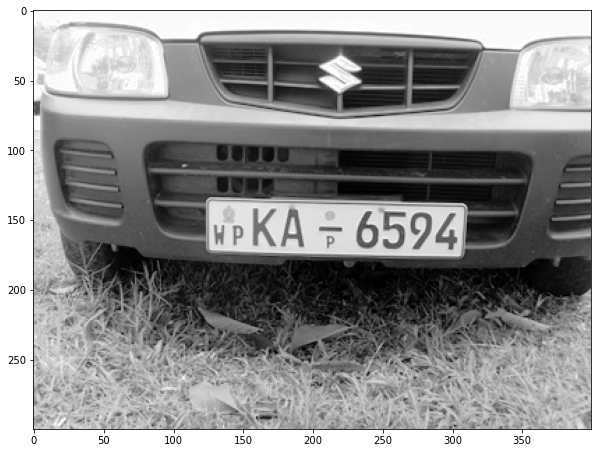

In [20]:
plt.figure(figsize=(10, 10))
equalized_1 = cv2.equalizeHist(test_images[1])
plt.imshow(equalized_1, cmap='gray')

Remove noise

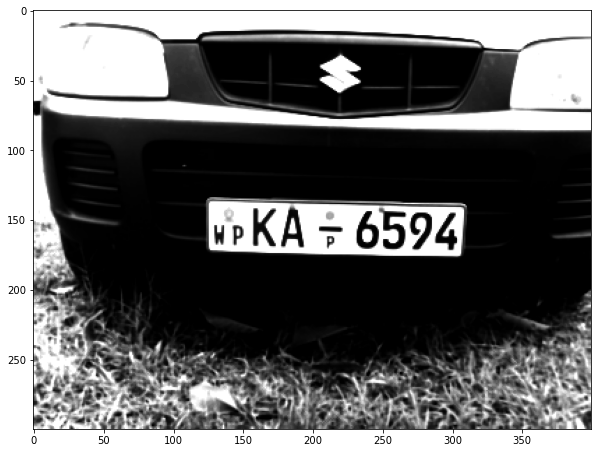

In [21]:
plt.figure(figsize=(10, 10))
denoised_1 = cv2.bilateralFilter(equalized_1, 3, 75, 75)
denoised_1 = contrast_stretch(denoised_1, 50, 10, 200, 255)
denoised_1 = power_transform(denoised_1, 4)
plt.imshow(denoised_1, cmap='gray')

Blackhat morphological transformation to enhance the text in the white background

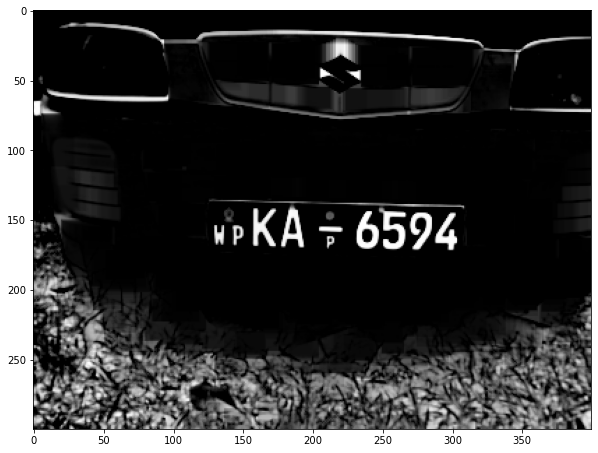

In [22]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
blackhat_1 = cv2.morphologyEx(denoised_1, cv2.MORPH_BLACKHAT, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(blackhat_1, cmap='gray')

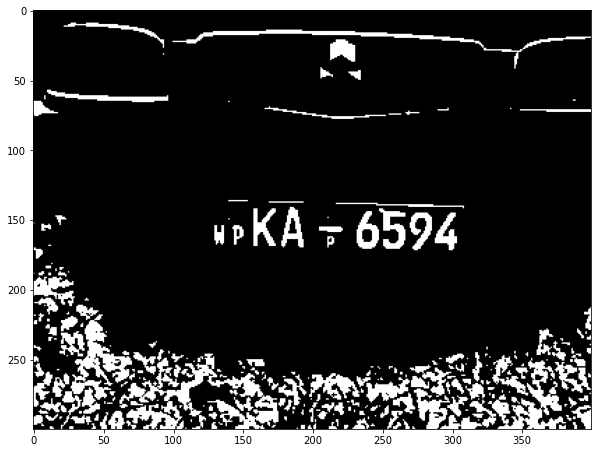

In [24]:
thresh_1 = cv2.threshold(blackhat_1, 100, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10, 10))
plt.imshow(thresh_1, cmap='gray')

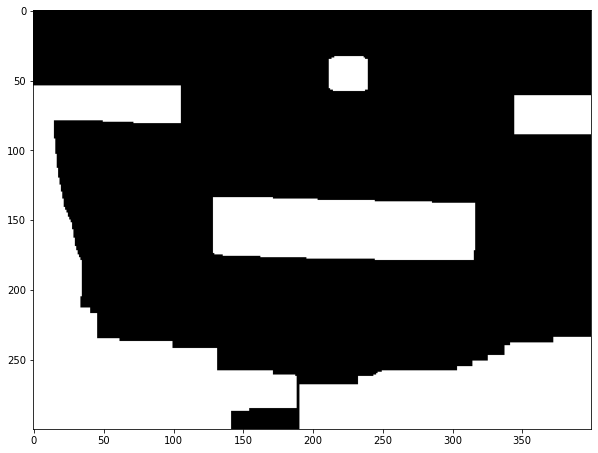

In [166]:
# Tophat transformation to enhance bright objects in dark background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 15))
tophat_1 = cv2.morphologyEx(denoised_1, cv2.MORPH_TOPHAT, kernel)
# Thresholding the tophat result
top_thresh_1 = cv2.threshold(tophat_1, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Eroding the thresholded image to remove background noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded_1 = cv2.erode(top_thresh_1, kernel, iterations=1)
# Closing the gaps (removing false negatives) in between white pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 3))
top_closing_1 = cv2.morphologyEx(eroded_1, cv2.MORPH_CLOSE, kernel, iterations=6)
# Remove noise (false positives) from foreground
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
top_opening_1 = cv2.morphologyEx(top_closing_1, cv2.MORPH_OPEN, kernel, iterations=3)
# Dilating to expand the foreground closer to the original (expected) size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated_1 = cv2.dilate(top_opening_1, kernel, iterations=2)
plt.figure(figsize=(10, 10))
plt.imshow(dilated_1, cmap='gray')

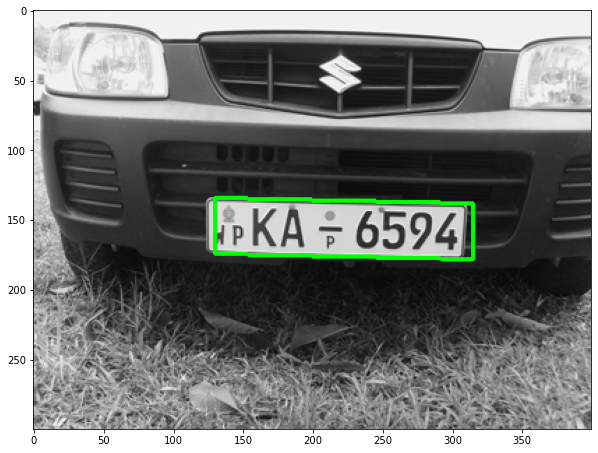

In [167]:
contours_1, hierarchy = cv2.findContours(dilated_1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_1 = sorted(contours_1, key=cv2.contourArea, reverse = True)[:10]
plate_contour_1 = None
for contour in contours_1:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.06 * perimeter, True).reshape(-1, 2)
    if len(approx) == 4:
        if check_aspect_ratio(contour=approx):
            plate_contour_1 = fix_contour(approx)
            break
    else:
        # Try to find a contour with 4 vertices that has a similar aspect ratio
        approx = find_rect_contour(approx)
        if check_aspect_ratio(contour=approx):
            plate_contour_1 = approx
            break
test_1 = test_images[1].copy()
test_1 = cv2.cvtColor(test_1, cv2.COLOR_GRAY2BGR)
if plate_contour_1 is not None:
    final_1 = cv2.drawContours(test_1, [plate_contour_1], -1, (0, 255, 0), 2)
else:
    final_1 = test_1
plt.figure(figsize=(10, 10))
plt.imshow(final_1)

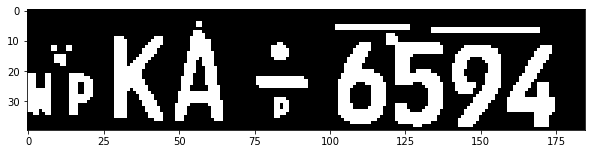

In [168]:
plate_contour_1 = sorted(plate_contour_1, key=lambda x: x[0])
top_left, top_right, bottom_left, bottom_right = plate_contour_1
if top_left[1] > top_right[1]:
    top_left, top_right = top_right, top_left
if bottom_left[1] > bottom_right[1]:
    bottom_left, bottom_right = bottom_right, bottom_left
height = max(top_right[1] - top_left[1], bottom_right[1] - bottom_left[1])
width = max(bottom_right[0] - top_right[0], bottom_left[0] - top_left[0])
cropped_1 = thresh_1[top_left[1]:top_left[1] + height, top_left[0]:top_left[0] + width]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
cropped_1 = cv2.morphologyEx(cropped_1, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(cropped_1, cmap='gray')

In [169]:
(num_labels, labels, stats, centroids) = cv2.connectedComponentsWithStats(cropped_1, 4, cv2.CV_32S)
print(f'Found {num_labels} connected components')

Found 18 connected components


Segmenting the license plate number into characters

Average area: 113.47058823529412


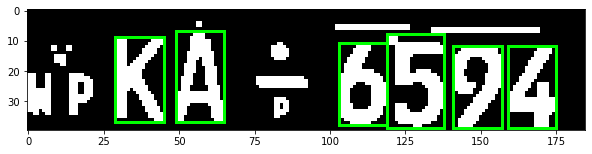

In [170]:
output = cropped_1.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

num_candidates_1 = []

avg_area = stats[1:, cv2.CC_STAT_AREA].mean()
print(f'Average area: {avg_area}')

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area * 3 > area > avg_area * 0.9 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        num_candidates_1.append((cropped_1[y:y + h, x:x + w], x))
num_candidates_1 = sorted(num_candidates_1, key=lambda x: x[1])
num_candidates_1 = [x[0] for x in num_candidates_1]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [171]:
for candidate in num_candidates_1:
    res = []
    for img in ground_truth_license:
        res.append(compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_license[res.argmin()])

K
A
6
6
9
4


Segmenting the province into characters

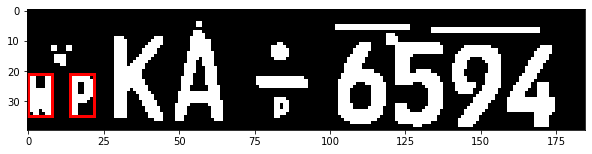

In [172]:
output = cropped_1.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

province_candidates_1 = []

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area / 2.5 < area < avg_area / 1.2 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
        province_candidates_1.append((cropped_1[y:y + h, x:x + w], x))
province_candidates_1 = sorted(province_candidates_1, key=lambda x: x[1])
province_candidates_1 = [x[0] for x in province_candidates_1]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [219]:
for candidate in province_candidates_1:
    res = []
    for img, label in zip(ground_truth_province, idx2label_province):
        res.append(cv2.minMaxLoc(cv2.matchTemplate(img, candidate, cv2.TM_SQDIFF))[0] + 6500 * compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_province[res.argmin()])

N
P


## Image 2

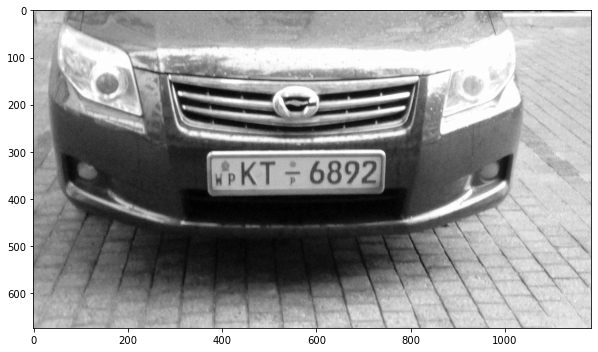

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(test_images[2], cmap='gray')

In [49]:
print(f'Brightness: {brightness(test_images[2])}')

Brightness: 140.38742832223915


Histogram equalization to improve contrast

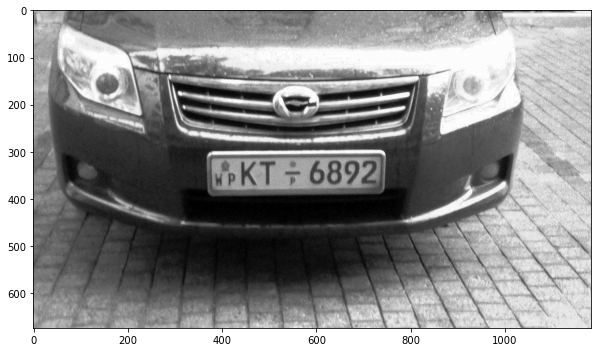

In [10]:
plt.figure(figsize=(10, 10))
equalized_2 = cv2.equalizeHist(test_images[2])
plt.imshow(equalized_2, cmap='gray')

Remove noise

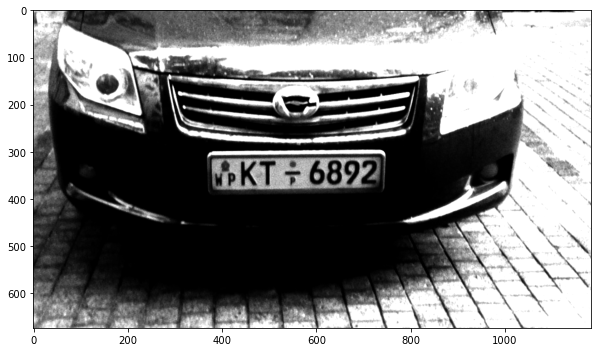

In [11]:
plt.figure(figsize=(10, 10))
denoised_2 = cv2.bilateralFilter(test_images[2], 3, 75, 75)
denoised_2 = contrast_stretch(denoised_2, 50, 5, 200, 255)
denoised_2 = power_transform(denoised_2, 3)
plt.imshow(denoised_2, cmap='gray')

In [64]:
cv2.imwrite('./metadata/hist_ref_1.png', test_images[2])

True

Blackhat morphological transformation to enhance the text in the white background

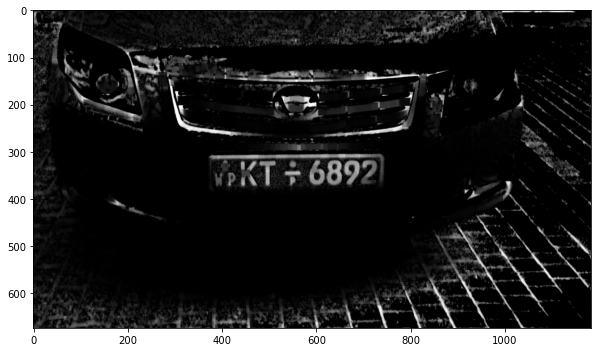

In [179]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
blackhat_2 = cv2.morphologyEx(denoised_2, cv2.MORPH_BLACKHAT, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(blackhat_2, cmap='gray')

Thresholding to extract the text

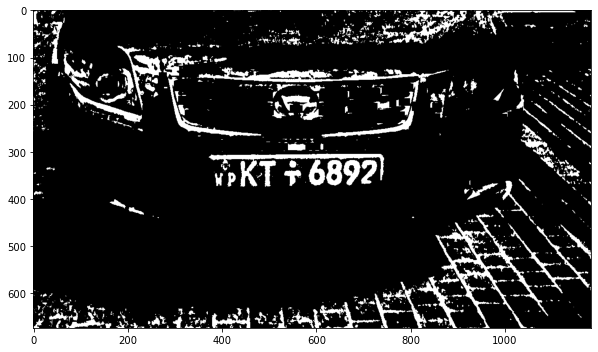

In [180]:
thresh_2 = cv2.threshold(blackhat_2, 50, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10, 10))
plt.imshow(thresh_2, cmap='gray')

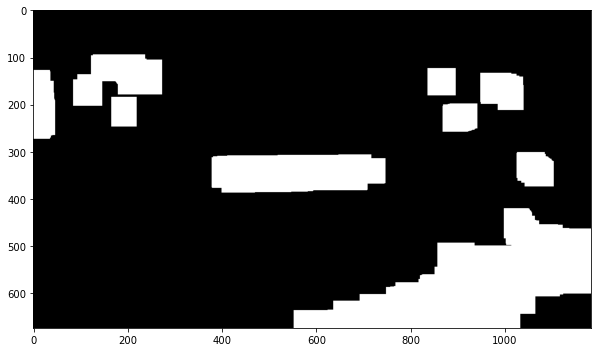

In [181]:
# Tophat transformation to enhance bright objects in dark background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 15))
tophat_2 = cv2.morphologyEx(equalized_2, cv2.MORPH_TOPHAT, kernel)
# Thresholding the tophat result
top_thresh_2 = cv2.threshold(tophat_2, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Eroding the thresholded image to remove background noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded_2 = cv2.erode(top_thresh_2, kernel, iterations=3)
# Closing the gaps (removing false negatives) in between white pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 3))
top_closing_2 = cv2.morphologyEx(eroded_2, cv2.MORPH_CLOSE, kernel, iterations=6)
# Remove noise (false positives) from foreground
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
top_opening_2 = cv2.morphologyEx(top_closing_2, cv2.MORPH_OPEN, kernel, iterations=8)
# Dilating to expand the foreground closer to the original (expected) size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated_2 = cv2.dilate(top_opening_2, kernel, iterations=5)
plt.figure(figsize=(10, 10))
plt.imshow(dilated_2, cmap='gray')

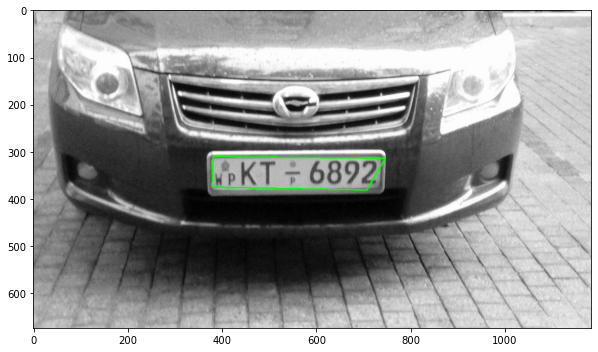

In [182]:
contours_2, hierarchy = cv2.findContours(dilated_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_2 = sorted(contours_2, key=cv2.contourArea, reverse = True)[:10]
plate_contour_2 = None
for contour in contours_2:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.06 * perimeter, True).reshape(-1, 2)
    if len(approx) == 4:
        if check_aspect_ratio(contour=approx):
            plate_contour_2 = fix_contour(approx)
            break
    else:
        # Try to find a contour with 4 vertices that has a similar aspect ratio
        approx = find_rect_contour(approx)
        if check_aspect_ratio(contour=approx):
            plate_contour_2 = approx
            break
test_2= test_images[2].copy()
test_2 = cv2.cvtColor(test_2, cv2.COLOR_GRAY2BGR)
if plate_contour_2 is not None:
    final_2 = cv2.drawContours(test_2, [plate_contour_2], -1, (0, 255, 0), 2)
else:
    final_2 = test_2
plt.figure(figsize=(10, 10))
plt.imshow(final_2)

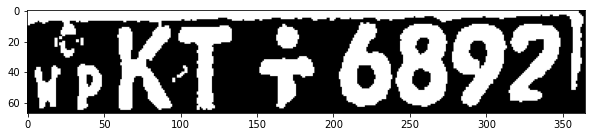

In [183]:
plate_contour_2 = sorted(plate_contour_2, key=lambda x: x[0])
top_left, top_right, bottom_left, bottom_right = plate_contour_2
if top_left[1] > top_right[1]:
    top_left, top_right = top_right, top_left
if bottom_left[1] > bottom_right[1]:
    bottom_left, bottom_right = bottom_right, bottom_left
height = max(top_right[1] - top_left[1], bottom_right[1] - bottom_left[1])
width = max(bottom_right[0] - top_right[0], bottom_left[0] - top_left[0])
cropped_2 = thresh_2[top_left[1]:top_left[1] + height, top_left[0]:top_left[0] + width]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
cropped_2 = cv2.morphologyEx(cropped_2, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(cropped_2, cmap='gray')

In [184]:
(num_labels, labels, stats, centroids) = cv2.connectedComponentsWithStats(cropped_2, 4, cv2.CV_32S)
print(f'Found {num_labels} connected components')

Found 17 connected components


Segmenting the license plate number into characters

Average area: 641.6875


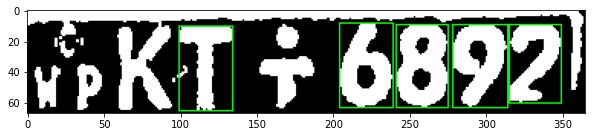

In [185]:
output = cropped_2.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

num_candidates_2 = []

avg_area = stats[1:, cv2.CC_STAT_AREA].mean()
print(f'Average area: {avg_area}')

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area * 3 > area > avg_area * 0.5 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        num_candidates_2.append((cropped_2[y:y + h, x:x + w], x))
num_candidates_2 = sorted(num_candidates_2, key=lambda x: x[1])
num_candidates_2 = [x[0] for x in num_candidates_2]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [186]:
for candidate in num_candidates_2:
    res = []
    for img in ground_truth_license:
        res.append(compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_license[res.argmin()])

T
6
8
9
2


Segmenting the province into characters

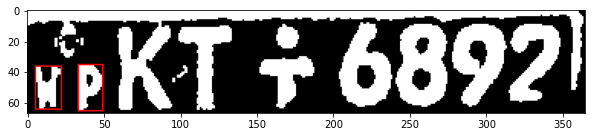

In [187]:
output = cropped_2.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

province_candidates_2 = []

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area / 3 < area < avg_area / 1.2 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
        province_candidates_2.append((cropped_2[y:y + h, x:x + w], x))
province_candidates_2 = sorted(province_candidates_2, key=lambda x: x[1])
province_candidates_2 = [x[0] for x in province_candidates_2]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [217]:
for candidate in province_candidates_2:
    res = []
    for img, label in zip(ground_truth_province, idx2label_province):
        res.append(cv2.minMaxLoc(cv2.matchTemplate(img, candidate, cv2.TM_SQDIFF))[0] + 6500 * compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_province[res.argmin()])

W
P


## Image 3

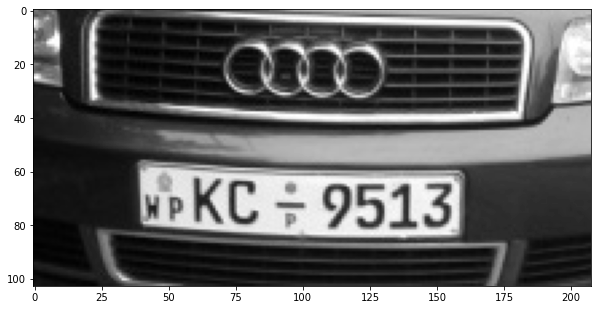

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(test_images[3], cmap='gray')

In [7]:
print(f'Brightness: {brightness(test_images[3])}')

Brightness: 91.70589058999253


Histogram equalization to improve contrast

Remove noise

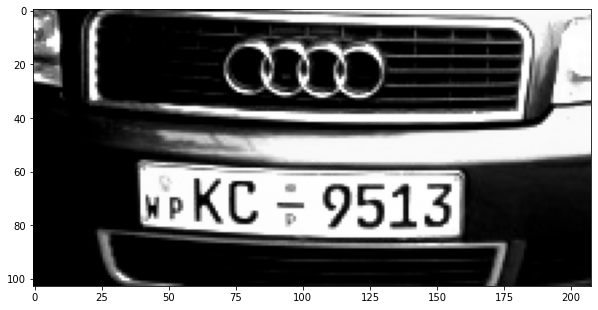

In [12]:
matched = match_histograms(test_images[3], denoised)
plt.figure(figsize=(10, 10))
plt.imshow(matched, cmap='gray')

In [13]:
denoised_3 = matched.astype(np.uint8)

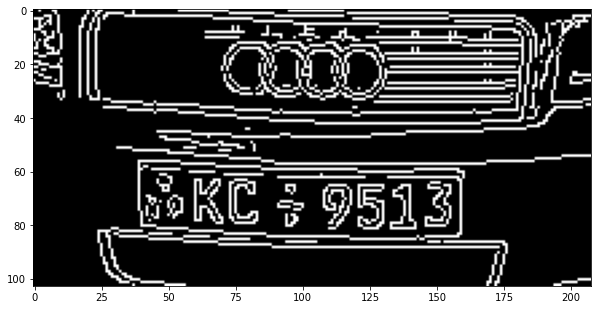

In [18]:
edges = cv2.Canny(denoised_3, 100, 200)
plt.figure(figsize=(10, 10))
plt.imshow(edges, cmap='gray')

In [25]:
contours_3, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

Blackhat morphological transformation to enhance the text in the white background

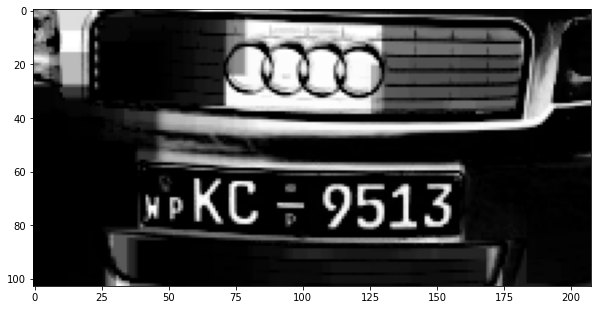

In [28]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
blackhat_3 = cv2.morphologyEx(denoised_3, cv2.MORPH_BLACKHAT, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(blackhat_3, cmap='gray')

Thresholding to extract the text

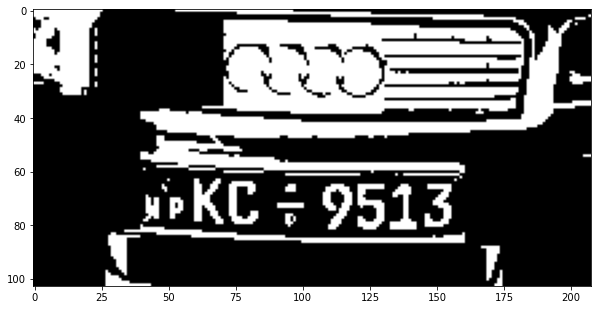

In [29]:
thresh_3 = cv2.threshold(blackhat_3, 50, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10, 10))
plt.imshow(thresh_3, cmap='gray')

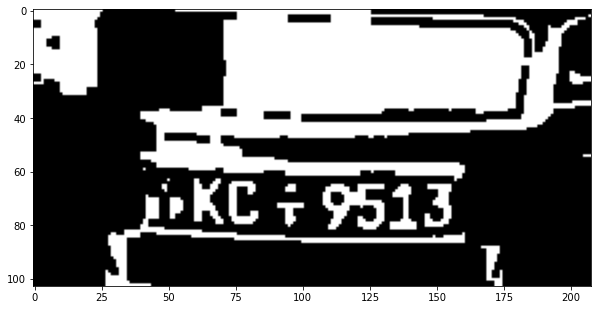

In [30]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closing_3 = cv2.morphologyEx(thresh_3, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(closing_3, cmap='gray')

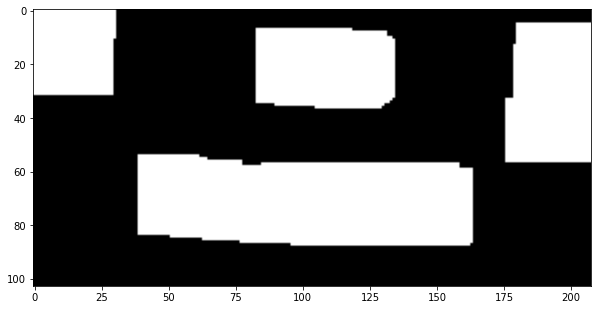

In [99]:
# Tophat transformation to enhance bright objects in dark background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 15))
tophat_3 = cv2.morphologyEx(equalized_3, cv2.MORPH_TOPHAT, kernel)
# Thresholding the tophat result
top_thresh_3 = cv2.threshold(tophat_3, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Eroding the thresholded image to remove background noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded_3 = cv2.erode(top_thresh_3, kernel, iterations=1)
# Closing the gaps (removing false negatives) in between white pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 3))
top_closing_3 = cv2.morphologyEx(eroded_3, cv2.MORPH_CLOSE, kernel, iterations=2)
# Remove noise (false positives) from foreground
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
top_opening_3 = cv2.morphologyEx(top_closing_3, cv2.MORPH_OPEN, kernel, iterations=3)
# Dilating to expand the foreground closer to the original (expected) size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated_3 = cv2.dilate(top_opening_3, kernel, iterations=2)
plt.figure(figsize=(10, 10))
plt.imshow(dilated_3, cmap='gray')

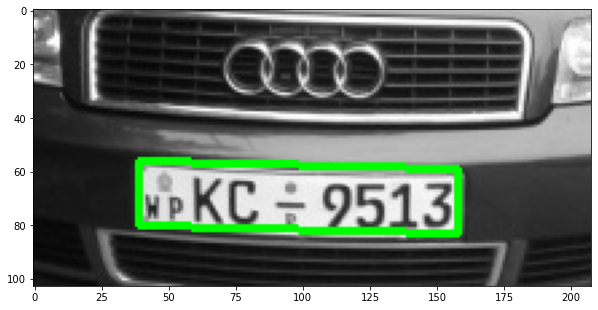

In [26]:
contours_3 = sorted(contours_3, key=cv2.contourArea, reverse = True)[:10]
plate_contour_3 = None
for contour in contours_3:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.06 * perimeter, True).reshape(-1, 2)
    if len(approx) == 4:
        if check_aspect_ratio(contour=approx, tolerance=0.25):
            plate_contour_3 = fix_contour(approx)
            break
    else:
        # Try to find a contour with 4 vertices that has a similar aspect ratio
        approx = find_rect_contour(approx)
        if check_aspect_ratio(contour=approx):
            plate_contour_3 = approx
            break
test_3 = test_images[3].copy()
test_3 = cv2.cvtColor(test_3, cv2.COLOR_GRAY2BGR)
if plate_contour_3 is not None:
    final_3 = cv2.drawContours(test_3, [plate_contour_3], -1, (0, 255, 0), 2)
else:
    final_3 = test_3
plt.figure(figsize=(10, 10))
plt.imshow(final_3)

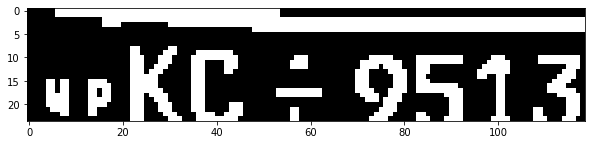

In [31]:
plate_contour_3 = sorted(plate_contour_3, key=lambda x: x[0])
top_left, top_right, bottom_left, bottom_right = plate_contour_3
if top_left[1] > top_right[1]:
    top_left, top_right = top_right, top_left
if bottom_left[1] > bottom_right[1]:
    bottom_left, bottom_right = bottom_right, bottom_left
height = max(top_right[1] - top_left[1], bottom_right[1] - bottom_left[1])
width = max(bottom_right[0] - top_right[0], bottom_left[0] - top_left[0])
cropped_3 = thresh_3[top_left[1]:top_left[1] + height, top_left[0]:top_left[0] + width]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
cropped_3 = cv2.morphologyEx(cropped_3, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(cropped_3, cmap='gray')

In [32]:
(num_labels, labels, stats, centroids) = cv2.connectedComponentsWithStats(cropped_3, 4, cv2.CV_32S)
print(f'Found {num_labels} connected components')

Found 15 connected components


Segmenting the license plate number into characters

Average area: 65.21428571428571


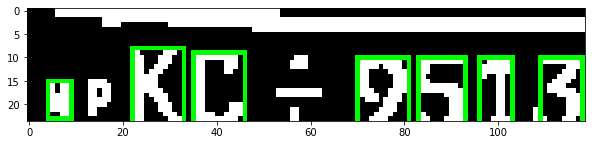

In [33]:
output = cropped_3.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

num_candidates_3 = []

avg_area = stats[1:, cv2.CC_STAT_AREA].mean()
print(f'Average area: {avg_area}')

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area * 3 > area > avg_area * 0.5 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        num_candidates_3.append((cropped_3[y:y + h, x:x + w], x))
num_candidates_3 = sorted(num_candidates_3, key=lambda x: x[1])
num_candidates_3 = [x[0] for x in num_candidates_3]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [34]:
for candidate in num_candidates_3:
    res = []
    for img in ground_truth_license:
        res.append(compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_license[res.argmin()])

N
K
C
9
5
1
3


Segmenting the province into characters

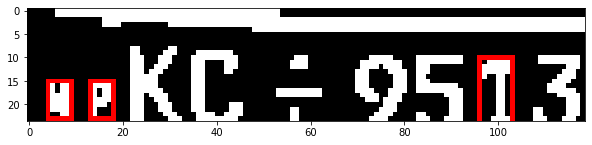

In [35]:
output = cropped_3.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

province_candidates_3 = []

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area / 3 < area < avg_area / 1.2 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
        province_candidates_3.append((cropped_3[y:y + h, x:x + w], x))
province_candidates_3 = sorted(province_candidates_3, key=lambda x: x[1])
province_candidates_3 = [x[0] for x in province_candidates_3]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [36]:
for candidate in province_candidates_3:
    res = []
    for img, label in zip(ground_truth_province[:-1], idx2label_province[:-1]):
        res.append(cv2.minMaxLoc(cv2.matchTemplate(img, candidate, cv2.TM_SQDIFF))[0] + 6500 * compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_province[res.argmin()])

N
P
S


## Image 4

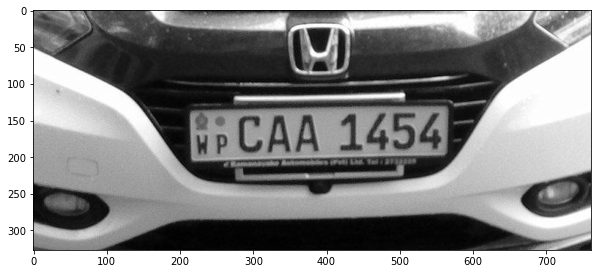

In [98]:
plt.figure(figsize=(10, 10))
plt.imshow(test_images[4], cmap='gray')

In [50]:
print(f'Brightness: {brightness(test_images[4])}')

Brightness: 117.20551100837166


Histogram equalization to improve contrast

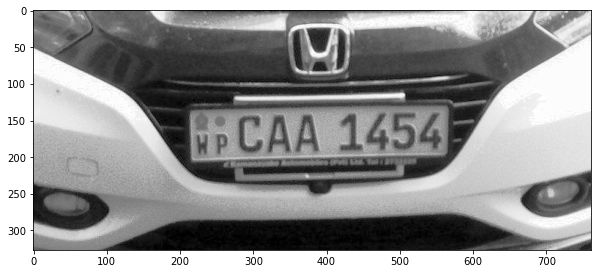

In [99]:
plt.figure(figsize=(10, 10))
equalized_4 = cv2.equalizeHist(test_images[4])
plt.imshow(equalized_4, cmap='gray')

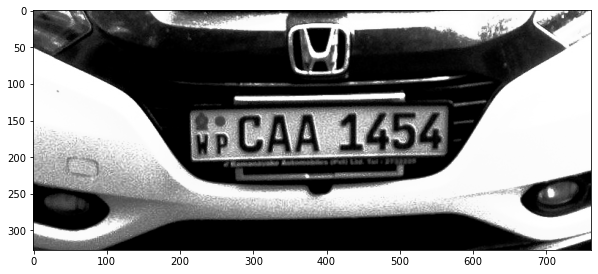

In [63]:
matched = match_histograms(test_images[4], denoised_2)
plt.figure(figsize=(10, 10))
plt.imshow(matched, cmap='gray')

Remove noise

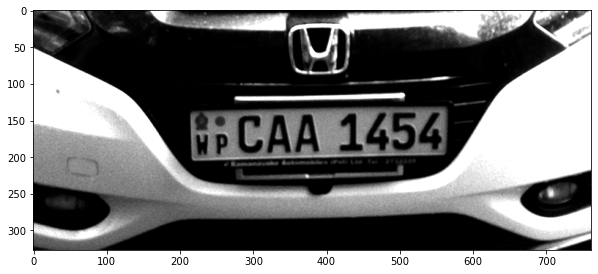

In [100]:
plt.figure(figsize=(10, 10))
denoised_4 = cv2.bilateralFilter(test_images[4], 3, 75, 75)
denoised_4 = contrast_stretch(denoised_4, 50, 10, 200, 255)
denoised_4 = power_transform(denoised_4, 2)
plt.imshow(denoised_4, cmap='gray')

Blackhat morphological transformation to enhance the text in the white background

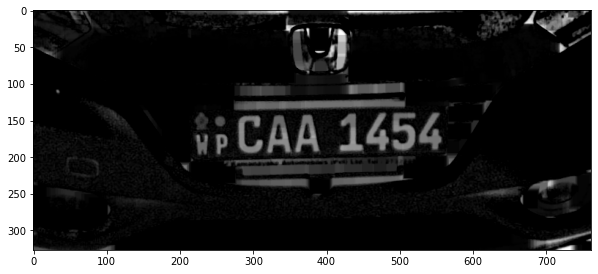

In [101]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
blackhat_4 = cv2.morphologyEx(denoised_4, cv2.MORPH_BLACKHAT, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(blackhat_4, cmap='gray')

Thresholding to extract the text

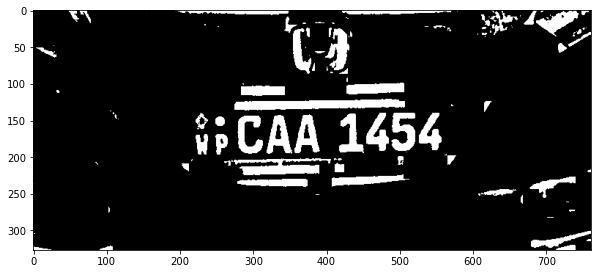

In [102]:
thresh_4 = cv2.threshold(blackhat_4, 50, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10, 10))
plt.imshow(thresh_4, cmap='gray')

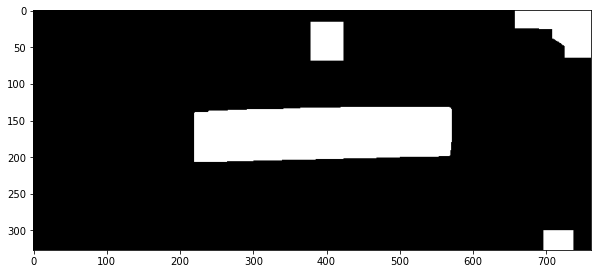

In [103]:
# Tophat transformation to enhance bright objects in dark background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 15))
tophat_4 = cv2.morphologyEx(denoised_4, cv2.MORPH_TOPHAT, kernel)
# Thresholding the tophat result
top_thresh_4 = cv2.threshold(tophat_4, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Eroding the thresholded image to remove background noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded_4 = cv2.erode(top_thresh_4, kernel, iterations=2)
# Closing the gaps (removing false negatives) in between white pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 3))
top_closing_4 = cv2.morphologyEx(eroded_4, cv2.MORPH_CLOSE, kernel, iterations=6)
# Remove noise (false positives) from foreground
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
top_opening_4 = cv2.morphologyEx(top_closing_4, cv2.MORPH_OPEN, kernel, iterations=8)
# Dilating to expand the foreground closer to the original (expected) size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated_4 = cv2.dilate(top_opening_4, kernel, iterations=2)
plt.figure(figsize=(10, 10))
plt.imshow(dilated_4, cmap='gray')

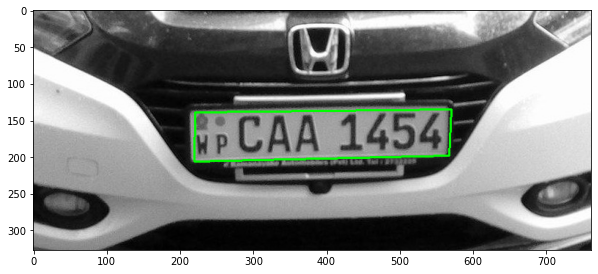

In [104]:
contours_4, hierarchy = cv2.findContours(dilated_4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_4 = sorted(contours_4, key=cv2.contourArea, reverse = True)[:10]
plate_contour_4 = None
for contour in contours_4:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.06 * perimeter, True).reshape(-1, 2)
    if len(approx) == 4:
        if check_aspect_ratio(contour=approx):
            plate_contour_4 = fix_contour(approx)
            break
    else:
        # Try to find a contour with 4 vertices that has a similar aspect ratio
        approx = find_rect_contour(approx)
        if check_aspect_ratio(contour=approx):
            plate_contour_4 = approx
            break
test_4 = test_images[4].copy()
test_4 = cv2.cvtColor(test_4, cv2.COLOR_GRAY2BGR)
if plate_contour_4 is not None:
    final_4 = cv2.drawContours(test_4, [plate_contour_4], -1, (0, 255, 0), 2)
else:
    final_4 = test_4
plt.figure(figsize=(10, 10))
plt.imshow(final_4)

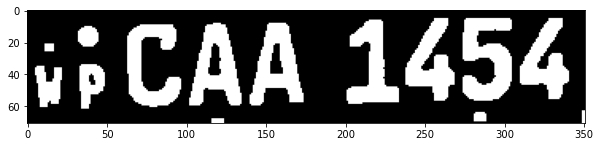

In [105]:
plate_contour_4 = sorted(plate_contour_4, key=lambda x: x[0])
top_left, top_right, bottom_left, bottom_right = plate_contour_4
if top_left[1] > top_right[1]:
    top_left, top_right = top_right, top_left
if bottom_left[1] > bottom_right[1]:
    bottom_left, bottom_right = bottom_right, bottom_left
width = max(bottom_right[0], bottom_left[0]) - min(top_right[0], top_left[0])
height = max(top_right[1], top_left[1]) - min(bottom_right[1], bottom_left[1])
cropped_4 = thresh_4[top_left[1]:top_left[1] + height, top_left[0]:top_left[0] + width]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
cropped_4 = cv2.morphologyEx(cropped_4, cv2.MORPH_OPEN, kernel, iterations=4)
plt.figure(figsize=(10, 10))
plt.imshow(cropped_4, cmap='gray')

In [106]:
(num_labels, labels, stats, centroids) = cv2.connectedComponentsWithStats(cropped_4, 4, cv2.CV_32S)
print(f'Found {num_labels} connected components')

Found 15 connected components


Segmenting the license plate number into characters

Average area: 518.0


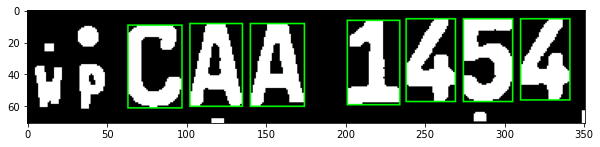

In [107]:
output = cropped_4.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

num_candidates_4 = []

avg_area = stats[1:, cv2.CC_STAT_AREA].mean()
print(f'Average area: {avg_area}')

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area * 3 > area > avg_area * 0.6 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        num_candidates_4.append((cropped_4[y:y + h, x:x + w], x))
num_candidates_4 = sorted(num_candidates_4, key=lambda x: x[1])
num_candidates_4 = [x[0] for x in num_candidates_4]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [108]:
for candidate in num_candidates_4:
    res = []
    for img in ground_truth_license:
        res.append(compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_license[res.argmin()])

C
A
A
1
4
5
4


Segmenting the province into characters

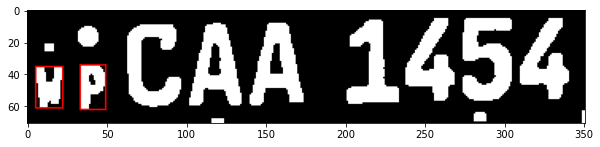

In [109]:
output = cropped_4.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

province_candidates_4 = []

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area / 3 < area < avg_area / 1.2 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
        province_candidates_4.append((cropped_4[y:y + h, x:x + w], x))
province_candidates_4 = sorted(province_candidates_4, key=lambda x: x[1])
province_candidates_4 = [x[0] for x in province_candidates_4]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [221]:
for candidate in province_candidates_4:
    res = []
    for img, label in zip(ground_truth_province, idx2label_province):
        res.append(cv2.minMaxLoc(cv2.matchTemplate(img, candidate, cv2.TM_SQDIFF))[0] + 6500 * compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_province[res.argmin()])

W
P


## Image 3

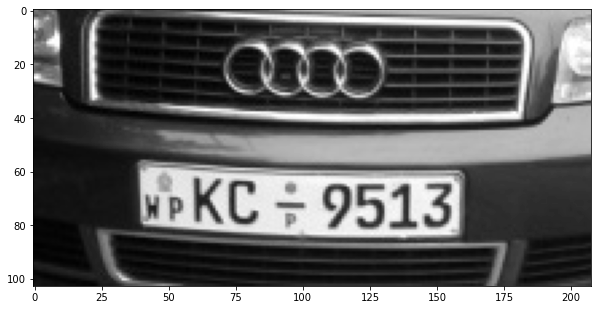

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(test_images[3], cmap='gray')

Histogram equalization to improve contrast

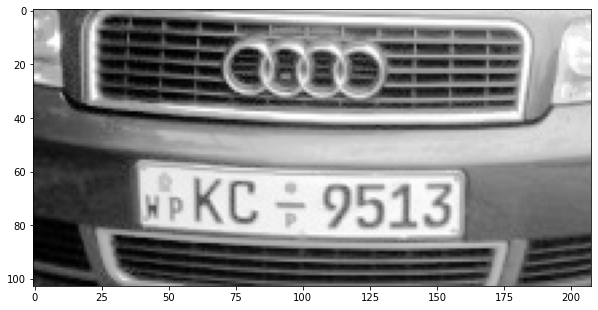

In [ ]:
plt.figure(figsize=(10, 10))
equalized_3 = cv2.equalizeHist(test_images[3])
plt.imshow(equalized_3, cmap='gray')

Remove noise

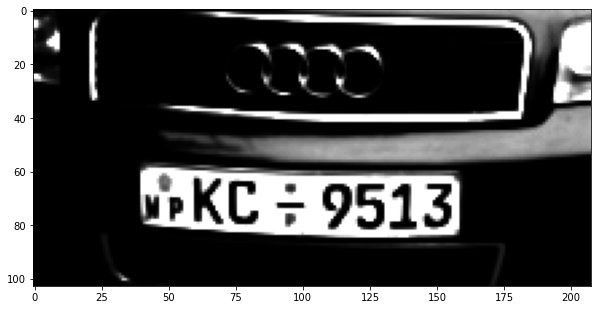

In [ ]:
plt.figure(figsize=(10, 10))
denoised_3 = cv2.bilateralFilter(test_images[3], 3, 75, 75)
denoised_3 = contrast_stretch(denoised_3, 50, 10, 200, 255)
denoised_3 = power_transform(denoised_3, 4)
plt.imshow(denoised_3, cmap='gray')

Blackhat morphological transformation to enhance the text in the white background

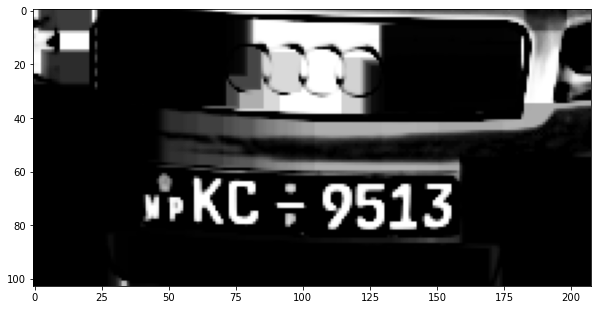

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
blackhat_3 = cv2.morphologyEx(denoised_3, cv2.MORPH_BLACKHAT, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(blackhat_3, cmap='gray')

Thresholding to extract the text

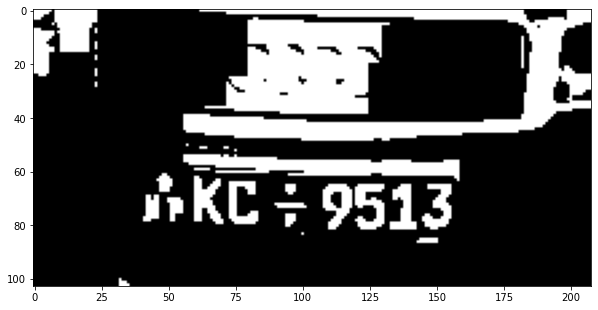

In [ ]:
thresh_3 = cv2.threshold(blackhat_3, 50, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10, 10))
plt.imshow(thresh_3, cmap='gray')

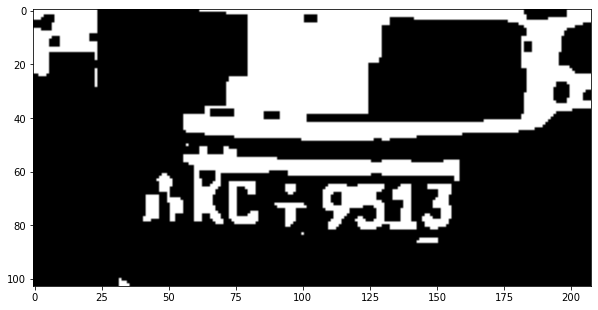

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closing_3 = cv2.morphologyEx(thresh_3, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(closing_3, cmap='gray')

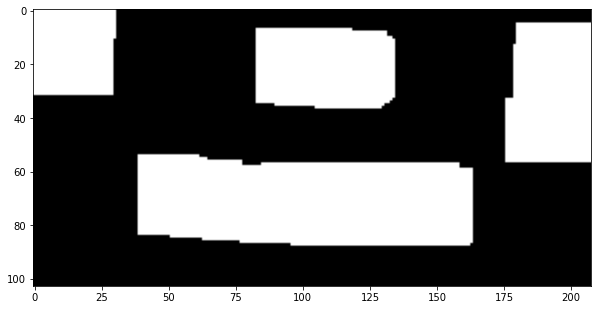

In [ ]:
# Tophat transformation to enhance bright objects in dark background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 15))
tophat_3 = cv2.morphologyEx(equalized_3, cv2.MORPH_TOPHAT, kernel)
# Thresholding the tophat result
top_thresh_3 = cv2.threshold(tophat_3, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Eroding the thresholded image to remove background noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded_3 = cv2.erode(top_thresh_3, kernel, iterations=1)
# Closing the gaps (removing false negatives) in between white pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 3))
top_closing_3 = cv2.morphologyEx(eroded_3, cv2.MORPH_CLOSE, kernel, iterations=2)
# Remove noise (false positives) from foreground
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
top_opening_3 = cv2.morphologyEx(top_closing_3, cv2.MORPH_OPEN, kernel, iterations=3)
# Dilating to expand the foreground closer to the original (expected) size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated_3 = cv2.dilate(top_opening_3, kernel, iterations=2)
plt.figure(figsize=(10, 10))
plt.imshow(dilated_3, cmap='gray')

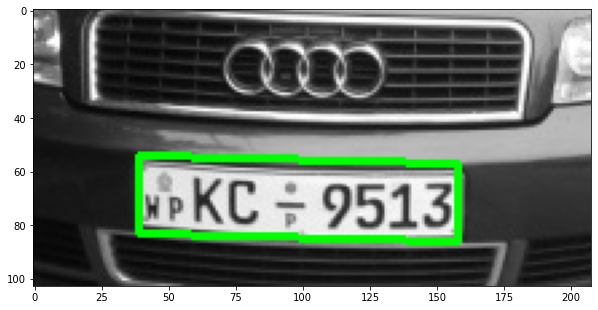

In [ ]:
contours_3, hierarchy = cv2.findContours(dilated_3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_3 = sorted(contours_3, key=cv2.contourArea, reverse = True)[:10]
plate_contour_3 = None
for contour in contours_3:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.06 * perimeter, True).reshape(-1, 2)
    if len(approx) == 4:
        if check_aspect_ratio(contour=approx, tolerance=0.25):
            plate_contour_3 = fix_contour(approx)
            break
    else:
        # Try to find a contour with 4 vertices that has a similar aspect ratio
        approx = find_rect_contour(approx)
        if check_aspect_ratio(contour=approx):
            plate_contour_3 = approx
            break
test_3 = test_images[3].copy()
test_3 = cv2.cvtColor(test_3, cv2.COLOR_GRAY2BGR)
if plate_contour_3 is not None:
    final_3 = cv2.drawContours(test_3, [plate_contour_3], -1, (0, 255, 0), 2)
else:
    final_3 = test_3
plt.figure(figsize=(10, 10))
plt.imshow(final_3)

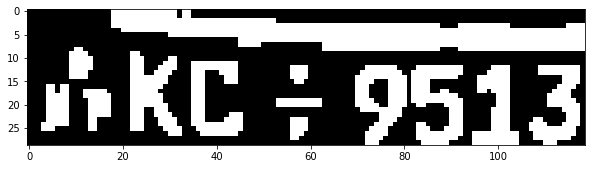

In [ ]:
plate_contour_3 = sorted(plate_contour_3, key=lambda x: x[0])
top_left, top_right, bottom_left, bottom_right = plate_contour_3
if top_left[1] > top_right[1]:
    top_left, top_right = top_right, top_left
if bottom_left[1] > bottom_right[1]:
    bottom_left, bottom_right = bottom_right, bottom_left
height = max(top_right[1] - top_left[1], bottom_right[1] - bottom_left[1])
width = max(bottom_right[0] - top_right[0], bottom_left[0] - top_left[0])
cropped_3 = thresh_3[top_left[1]:top_left[1] + height, top_left[0]:top_left[0] + width]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
cropped_3 = cv2.morphologyEx(cropped_3, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(cropped_3, cmap='gray')

In [ ]:
(num_labels, labels, stats, centroids) = cv2.connectedComponentsWithStats(cropped_3, 4, cv2.CV_32S)
print(f'Found {num_labels} connected components')

Found 14 connected components


Segmenting the license plate number into characters

Average area: 102.38461538461539


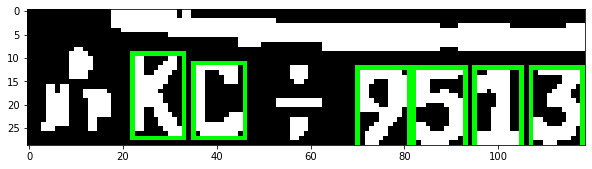

In [ ]:
output = cropped_3.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

num_candidates_3 = []

avg_area = stats[1:, cv2.CC_STAT_AREA].mean()
print(f'Average area: {avg_area}')

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area * 3 > area > avg_area * 0.5 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        num_candidates_3.append((cropped_3[y:y + h, x:x + w], x))
num_candidates_3 = sorted(num_candidates_3, key=lambda x: x[1])
num_candidates_3 = [x[0] for x in num_candidates_3]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [ ]:
for candidate in num_candidates_3:
    res = []
    for img in ground_truth_license:
        res.append(compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_license[res.argmin()])

K
C
9
5
I
3


Segmenting the province into characters

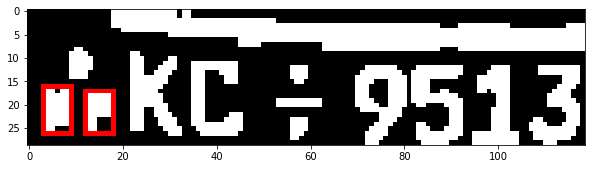

In [ ]:
output = cropped_3.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

province_candidates_3 = []

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area / 3 < area < avg_area / 1.2 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
        province_candidates_3.append((cropped_3[y:y + h, x:x + w], x))
province_candidates_3 = sorted(province_candidates_3, key=lambda x: x[1])
province_candidates_3 = [x[0] for x in province_candidates_3]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [ ]:
for candidate in province_candidates_3:
    res = []
    for img, label in zip(ground_truth_province[:-1], idx2label_province[:-1]):
        res.append(cv2.minMaxLoc(cv2.matchTemplate(img, candidate, cv2.TM_SQDIFF))[0] + 6500 * compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_province[res.argmin()])

W
P


## Image 4

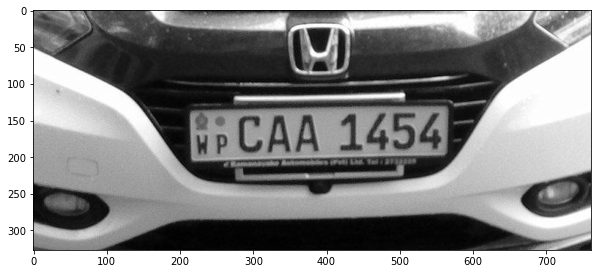

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(test_images[4], cmap='gray')

Histogram equalization to improve contrast

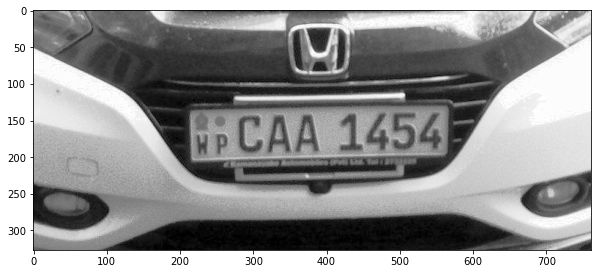

In [ ]:
plt.figure(figsize=(10, 10))
equalized_4 = cv2.equalizeHist(test_images[4])
plt.imshow(equalized_4, cmap='gray')

Remove noise

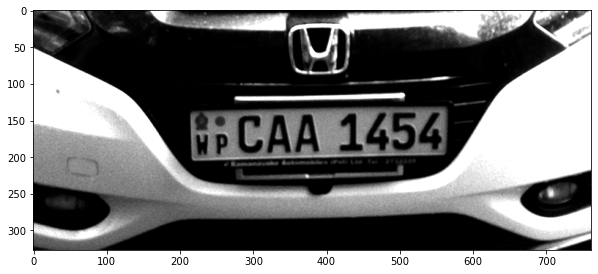

In [ ]:
plt.figure(figsize=(10, 10))
denoised_4 = cv2.bilateralFilter(test_images[4], 3, 75, 75)
denoised_4 = contrast_stretch(denoised_4, 50, 10, 200, 255)
denoised_4 = power_transform(denoised_4, 2)
plt.imshow(denoised_4, cmap='gray')

Blackhat morphological transformation to enhance the text in the white background

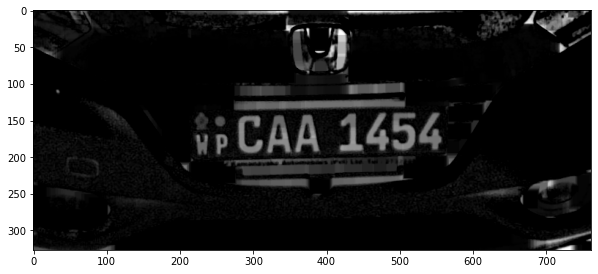

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
blackhat_4 = cv2.morphologyEx(denoised_4, cv2.MORPH_BLACKHAT, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(blackhat_4, cmap='gray')

Thresholding to extract the text

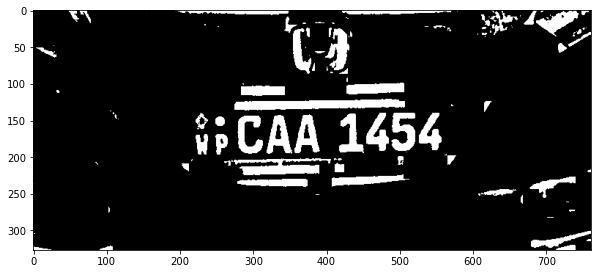

In [ ]:
thresh_4 = cv2.threshold(blackhat_4, 50, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10, 10))
plt.imshow(thresh_4, cmap='gray')

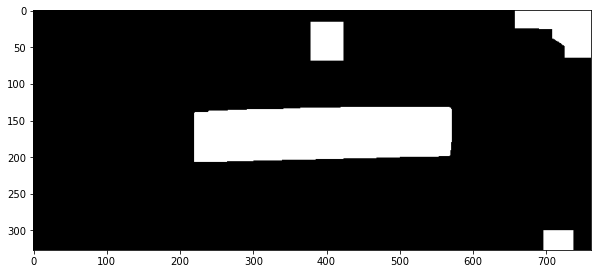

In [ ]:
# Tophat transformation to enhance bright objects in dark background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 15))
tophat_4 = cv2.morphologyEx(denoised_4, cv2.MORPH_TOPHAT, kernel)
# Thresholding the tophat result
top_thresh_4 = cv2.threshold(tophat_4, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Eroding the thresholded image to remove background noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded_4 = cv2.erode(top_thresh_4, kernel, iterations=2)
# Closing the gaps (removing false negatives) in between white pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 3))
top_closing_4 = cv2.morphologyEx(eroded_4, cv2.MORPH_CLOSE, kernel, iterations=6)
# Remove noise (false positives) from foreground
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
top_opening_4 = cv2.morphologyEx(top_closing_4, cv2.MORPH_OPEN, kernel, iterations=8)
# Dilating to expand the foreground closer to the original (expected) size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated_4 = cv2.dilate(top_opening_4, kernel, iterations=2)
plt.figure(figsize=(10, 10))
plt.imshow(dilated_4, cmap='gray')

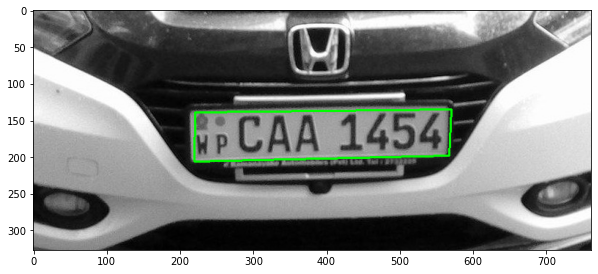

In [ ]:
contours_4, hierarchy = cv2.findContours(dilated_4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_4 = sorted(contours_4, key=cv2.contourArea, reverse = True)[:10]
plate_contour_4 = None
for contour in contours_4:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.06 * perimeter, True).reshape(-1, 2)
    if len(approx) == 4:
        if check_aspect_ratio(contour=approx):
            plate_contour_4 = fix_contour(approx)
            break
    else:
        # Try to find a contour with 4 vertices that has a similar aspect ratio
        approx = find_rect_contour(approx)
        if check_aspect_ratio(contour=approx):
            plate_contour_4 = approx
            break
test_4 = test_images[4].copy()
test_4 = cv2.cvtColor(test_4, cv2.COLOR_GRAY2BGR)
if plate_contour_4 is not None:
    final_4 = cv2.drawContours(test_4, [plate_contour_4], -1, (0, 255, 0), 2)
else:
    final_4 = test_4
plt.figure(figsize=(10, 10))
plt.imshow(final_4)

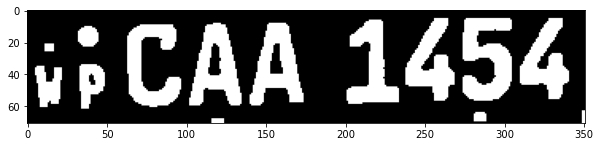

In [ ]:
plate_contour_4 = sorted(plate_contour_4, key=lambda x: x[0])
top_left, top_right, bottom_left, bottom_right = plate_contour_4
if top_left[1] > top_right[1]:
    top_left, top_right = top_right, top_left
if bottom_left[1] > bottom_right[1]:
    bottom_left, bottom_right = bottom_right, bottom_left
width = max(bottom_right[0], bottom_left[0]) - min(top_right[0], top_left[0])
height = max(top_right[1], top_left[1]) - min(bottom_right[1], bottom_left[1])
cropped_4 = thresh_4[top_left[1]:top_left[1] + height, top_left[0]:top_left[0] + width]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
cropped_4 = cv2.morphologyEx(cropped_4, cv2.MORPH_OPEN, kernel, iterations=4)
plt.figure(figsize=(10, 10))
plt.imshow(cropped_4, cmap='gray')

In [ ]:
(num_labels, labels, stats, centroids) = cv2.connectedComponentsWithStats(cropped_4, 4, cv2.CV_32S)
print(f'Found {num_labels} connected components')

Found 15 connected components


Segmenting the license plate number into characters

Average area: 518.0


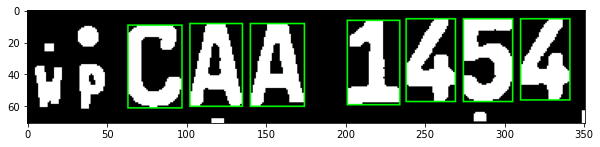

In [ ]:
output = cropped_4.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

num_candidates_4 = []

avg_area = stats[1:, cv2.CC_STAT_AREA].mean()
print(f'Average area: {avg_area}')

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area * 3 > area > avg_area * 0.6 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        num_candidates_4.append((cropped_4[y:y + h, x:x + w], x))
num_candidates_4 = sorted(num_candidates_4, key=lambda x: x[1])
num_candidates_4 = [x[0] for x in num_candidates_4]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [ ]:
for candidate in num_candidates_4:
    res = []
    for img in ground_truth_license:
        res.append(compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_license[res.argmin()])

C
A
A
1
4
5
4


Segmenting the province into characters

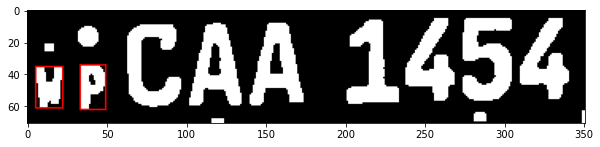

In [ ]:
output = cropped_4.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

province_candidates_4 = []

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area / 3 < area < avg_area / 1.2 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
        province_candidates_4.append((cropped_4[y:y + h, x:x + w], x))
province_candidates_4 = sorted(province_candidates_4, key=lambda x: x[1])
province_candidates_4 = [x[0] for x in province_candidates_4]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [ ]:
for candidate in province_candidates_4:
    res = []
    for img, label in zip(ground_truth_province, idx2label_province):
        res.append(cv2.minMaxLoc(cv2.matchTemplate(img, candidate, cv2.TM_SQDIFF))[0] + 6500 * compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_province[res.argmin()])

W
P


## Image 5

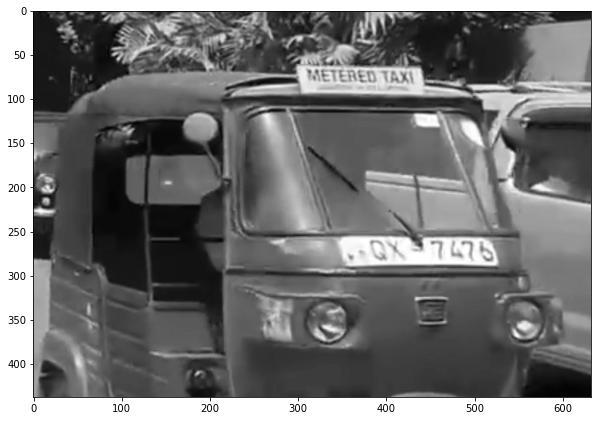

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(test_images[5], cmap='gray')

In [15]:
print(f'Brightness: {brightness(test_images[5])}')

Brightness: 94.8276381945797


Match Histograms

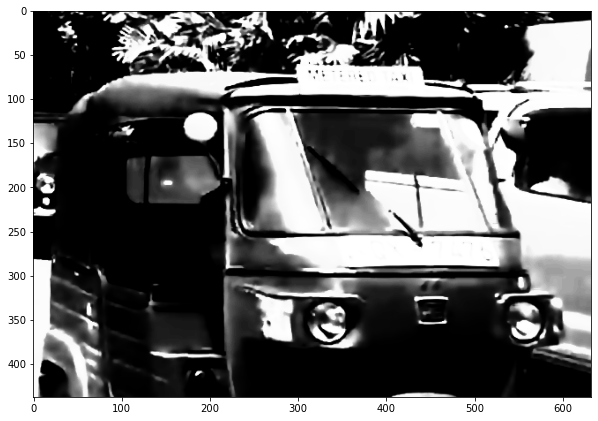

In [28]:
matched_5 = match_histograms(filtered, denoised)
plt.figure(figsize=(10, 10))
plt.imshow(matched_5, cmap='gray')

Blackhat morphological transformation to enhance the text in the white background

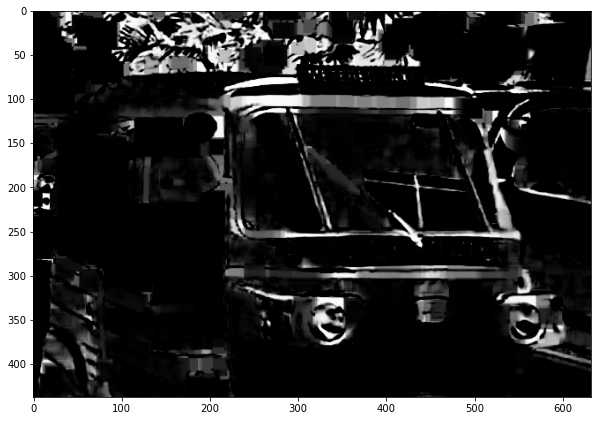

In [19]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
blackhat_5 = cv2.morphologyEx(matched_5, cv2.MORPH_BLACKHAT, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(blackhat_5, cmap='gray')

Thresholding to extract the text

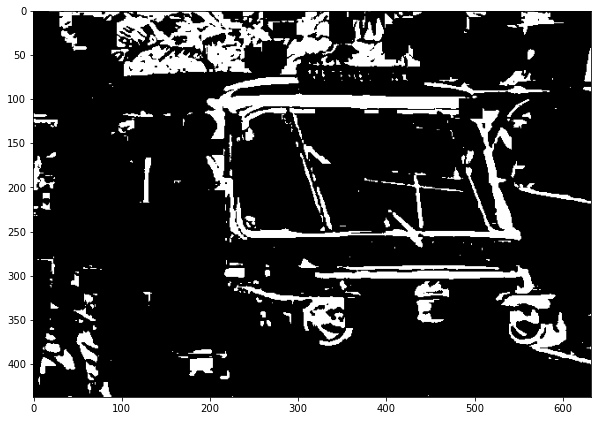

In [20]:
thresh_5 = cv2.threshold(blackhat_5, 50, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10, 10))
plt.imshow(thresh_5, cmap='gray')

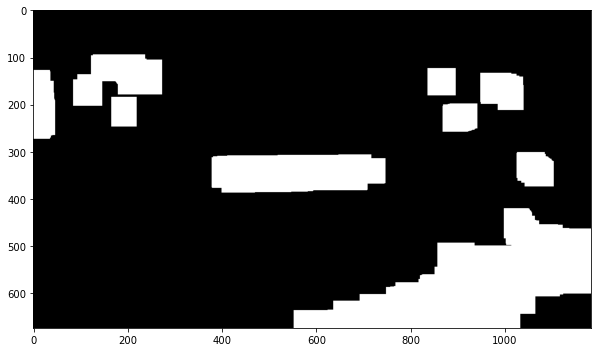

In [ ]:
# Tophat transformation to enhance bright objects in dark background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 15))
tophat_2 = cv2.morphologyEx(equalized_2, cv2.MORPH_TOPHAT, kernel)
# Thresholding the tophat result
top_thresh_2 = cv2.threshold(tophat_2, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Eroding the thresholded image to remove background noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded_2 = cv2.erode(top_thresh_2, kernel, iterations=3)
# Closing the gaps (removing false negatives) in between white pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 3))
top_closing_2 = cv2.morphologyEx(eroded_2, cv2.MORPH_CLOSE, kernel, iterations=6)
# Remove noise (false positives) from foreground
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
top_opening_2 = cv2.morphologyEx(top_closing_2, cv2.MORPH_OPEN, kernel, iterations=8)
# Dilating to expand the foreground closer to the original (expected) size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated_2 = cv2.dilate(top_opening_2, kernel, iterations=5)
plt.figure(figsize=(10, 10))
plt.imshow(dilated_2, cmap='gray')

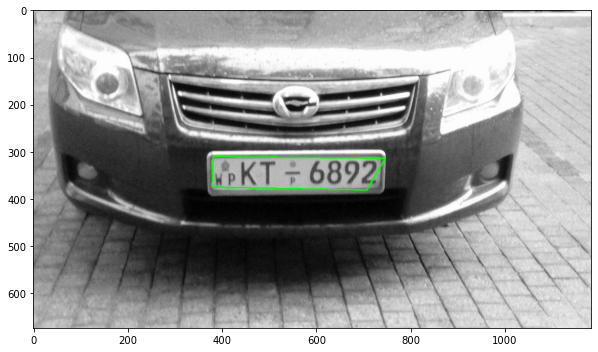

In [ ]:
contours_2, hierarchy = cv2.findContours(dilated_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_2 = sorted(contours_2, key=cv2.contourArea, reverse = True)[:10]
plate_contour_2 = None
for contour in contours_2:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.06 * perimeter, True).reshape(-1, 2)
    if len(approx) == 4:
        if check_aspect_ratio(contour=approx):
            plate_contour_2 = fix_contour(approx)
            break
    else:
        # Try to find a contour with 4 vertices that has a similar aspect ratio
        approx = find_rect_contour(approx)
        if check_aspect_ratio(contour=approx):
            plate_contour_2 = approx
            break
test_2= test_images[2].copy()
test_2 = cv2.cvtColor(test_2, cv2.COLOR_GRAY2BGR)
if plate_contour_2 is not None:
    final_2 = cv2.drawContours(test_2, [plate_contour_2], -1, (0, 255, 0), 2)
else:
    final_2 = test_2
plt.figure(figsize=(10, 10))
plt.imshow(final_2)

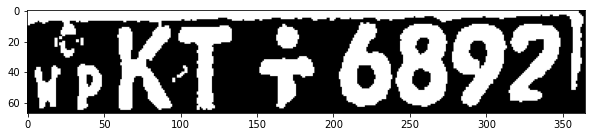

In [ ]:
plate_contour_2 = sorted(plate_contour_2, key=lambda x: x[0])
top_left, top_right, bottom_left, bottom_right = plate_contour_2
if top_left[1] > top_right[1]:
    top_left, top_right = top_right, top_left
if bottom_left[1] > bottom_right[1]:
    bottom_left, bottom_right = bottom_right, bottom_left
height = max(top_right[1] - top_left[1], bottom_right[1] - bottom_left[1])
width = max(bottom_right[0] - top_right[0], bottom_left[0] - top_left[0])
cropped_2 = thresh_2[top_left[1]:top_left[1] + height, top_left[0]:top_left[0] + width]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
cropped_2 = cv2.morphologyEx(cropped_2, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(cropped_2, cmap='gray')

In [ ]:
(num_labels, labels, stats, centroids) = cv2.connectedComponentsWithStats(cropped_2, 4, cv2.CV_32S)
print(f'Found {num_labels} connected components')

Found 17 connected components


Segmenting the license plate number into characters

Average area: 641.6875


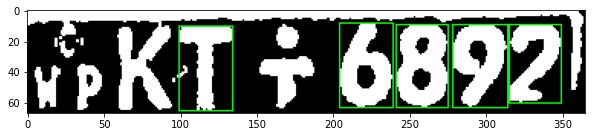

In [ ]:
output = cropped_2.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

num_candidates_2 = []

avg_area = stats[1:, cv2.CC_STAT_AREA].mean()
print(f'Average area: {avg_area}')

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area * 3 > area > avg_area * 0.5 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        num_candidates_2.append((cropped_2[y:y + h, x:x + w], x))
num_candidates_2 = sorted(num_candidates_2, key=lambda x: x[1])
num_candidates_2 = [x[0] for x in num_candidates_2]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [ ]:
for candidate in num_candidates_2:
    res = []
    for img in ground_truth_license:
        res.append(compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_license[res.argmin()])

T
6
8
9
2


Segmenting the province into characters

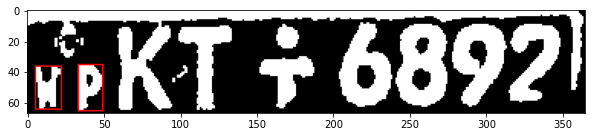

In [ ]:
output = cropped_2.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

province_candidates_2 = []

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area / 3 < area < avg_area / 1.2 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
        province_candidates_2.append((cropped_2[y:y + h, x:x + w], x))
province_candidates_2 = sorted(province_candidates_2, key=lambda x: x[1])
province_candidates_2 = [x[0] for x in province_candidates_2]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [ ]:
for candidate in province_candidates_2:
    res = []
    for img, label in zip(ground_truth_province, idx2label_province):
        res.append(cv2.minMaxLoc(cv2.matchTemplate(img, candidate, cv2.TM_SQDIFF))[0] + 6500 * compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_province[res.argmin()])

W
P


## Image 3

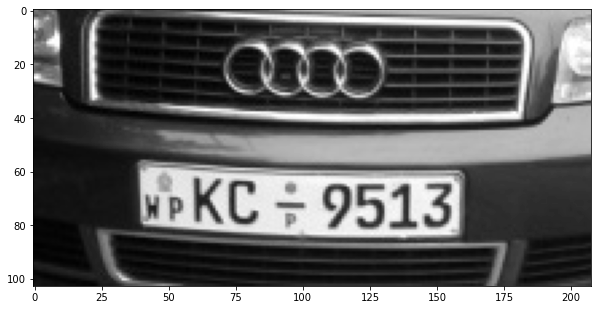

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(test_images[3], cmap='gray')

Histogram equalization to improve contrast

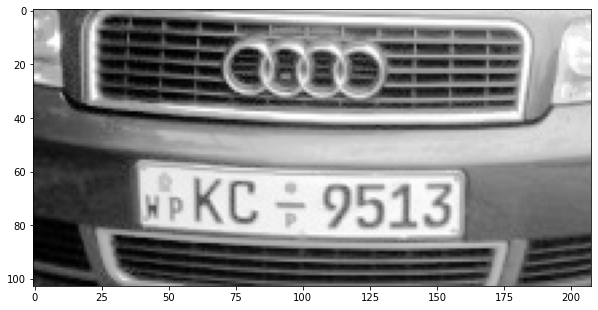

In [ ]:
plt.figure(figsize=(10, 10))
equalized_3 = cv2.equalizeHist(test_images[3])
plt.imshow(equalized_3, cmap='gray')

Remove noise

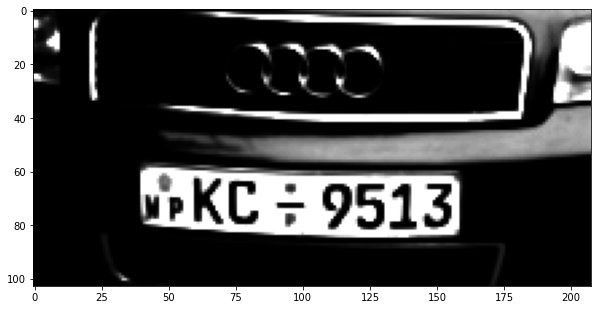

In [ ]:
plt.figure(figsize=(10, 10))
denoised_3 = cv2.bilateralFilter(test_images[3], 3, 75, 75)
denoised_3 = contrast_stretch(denoised_3, 50, 10, 200, 255)
denoised_3 = power_transform(denoised_3, 4)
plt.imshow(denoised_3, cmap='gray')

Blackhat morphological transformation to enhance the text in the white background

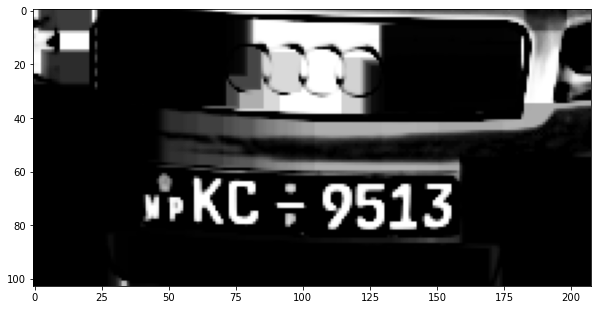

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
blackhat_3 = cv2.morphologyEx(denoised_3, cv2.MORPH_BLACKHAT, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(blackhat_3, cmap='gray')

Thresholding to extract the text

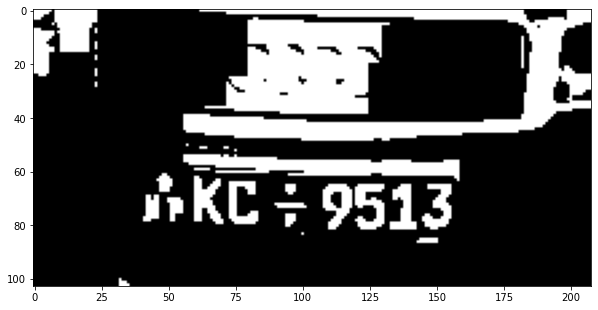

In [ ]:
thresh_3 = cv2.threshold(blackhat_3, 50, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10, 10))
plt.imshow(thresh_3, cmap='gray')

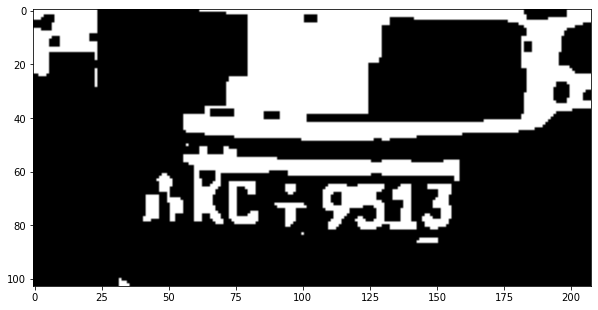

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closing_3 = cv2.morphologyEx(thresh_3, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(closing_3, cmap='gray')

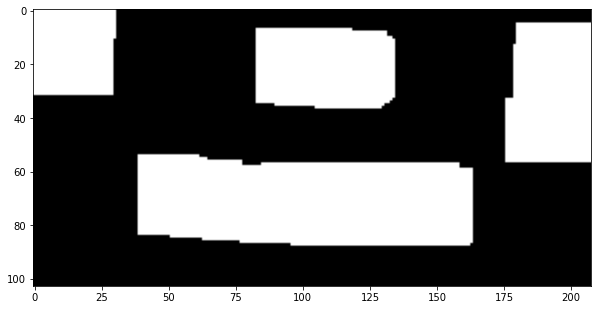

In [ ]:
# Tophat transformation to enhance bright objects in dark background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 15))
tophat_3 = cv2.morphologyEx(equalized_3, cv2.MORPH_TOPHAT, kernel)
# Thresholding the tophat result
top_thresh_3 = cv2.threshold(tophat_3, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Eroding the thresholded image to remove background noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded_3 = cv2.erode(top_thresh_3, kernel, iterations=1)
# Closing the gaps (removing false negatives) in between white pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 3))
top_closing_3 = cv2.morphologyEx(eroded_3, cv2.MORPH_CLOSE, kernel, iterations=2)
# Remove noise (false positives) from foreground
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
top_opening_3 = cv2.morphologyEx(top_closing_3, cv2.MORPH_OPEN, kernel, iterations=3)
# Dilating to expand the foreground closer to the original (expected) size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated_3 = cv2.dilate(top_opening_3, kernel, iterations=2)
plt.figure(figsize=(10, 10))
plt.imshow(dilated_3, cmap='gray')

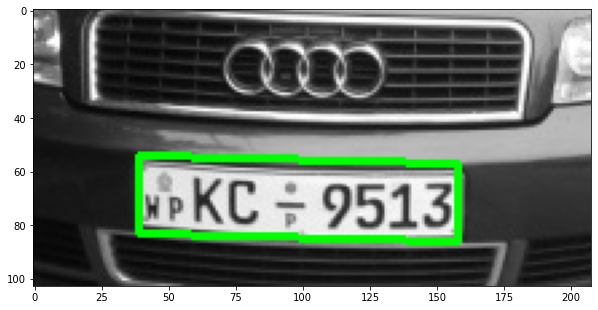

In [ ]:
contours_3, hierarchy = cv2.findContours(dilated_3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_3 = sorted(contours_3, key=cv2.contourArea, reverse = True)[:10]
plate_contour_3 = None
for contour in contours_3:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.06 * perimeter, True).reshape(-1, 2)
    if len(approx) == 4:
        if check_aspect_ratio(contour=approx, tolerance=0.25):
            plate_contour_3 = fix_contour(approx)
            break
    else:
        # Try to find a contour with 4 vertices that has a similar aspect ratio
        approx = find_rect_contour(approx)
        if check_aspect_ratio(contour=approx):
            plate_contour_3 = approx
            break
test_3 = test_images[3].copy()
test_3 = cv2.cvtColor(test_3, cv2.COLOR_GRAY2BGR)
if plate_contour_3 is not None:
    final_3 = cv2.drawContours(test_3, [plate_contour_3], -1, (0, 255, 0), 2)
else:
    final_3 = test_3
plt.figure(figsize=(10, 10))
plt.imshow(final_3)

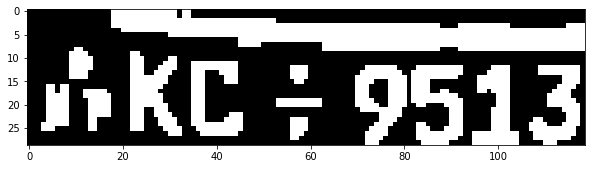

In [ ]:
plate_contour_3 = sorted(plate_contour_3, key=lambda x: x[0])
top_left, top_right, bottom_left, bottom_right = plate_contour_3
if top_left[1] > top_right[1]:
    top_left, top_right = top_right, top_left
if bottom_left[1] > bottom_right[1]:
    bottom_left, bottom_right = bottom_right, bottom_left
height = max(top_right[1] - top_left[1], bottom_right[1] - bottom_left[1])
width = max(bottom_right[0] - top_right[0], bottom_left[0] - top_left[0])
cropped_3 = thresh_3[top_left[1]:top_left[1] + height, top_left[0]:top_left[0] + width]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
cropped_3 = cv2.morphologyEx(cropped_3, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(cropped_3, cmap='gray')

In [ ]:
(num_labels, labels, stats, centroids) = cv2.connectedComponentsWithStats(cropped_3, 4, cv2.CV_32S)
print(f'Found {num_labels} connected components')

Found 14 connected components


Segmenting the license plate number into characters

Average area: 102.38461538461539


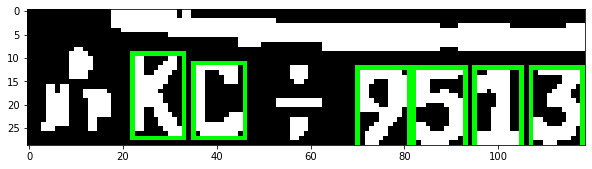

In [ ]:
output = cropped_3.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

num_candidates_3 = []

avg_area = stats[1:, cv2.CC_STAT_AREA].mean()
print(f'Average area: {avg_area}')

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area * 3 > area > avg_area * 0.5 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        num_candidates_3.append((cropped_3[y:y + h, x:x + w], x))
num_candidates_3 = sorted(num_candidates_3, key=lambda x: x[1])
num_candidates_3 = [x[0] for x in num_candidates_3]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [ ]:
for candidate in num_candidates_3:
    res = []
    for img in ground_truth_license:
        res.append(compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_license[res.argmin()])

K
C
9
5
I
3


Segmenting the province into characters

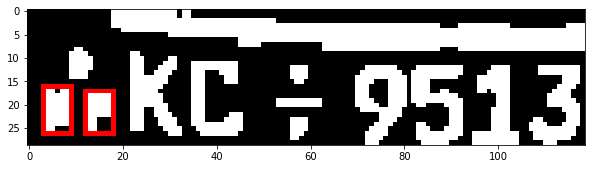

In [ ]:
output = cropped_3.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

province_candidates_3 = []

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area / 3 < area < avg_area / 1.2 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
        province_candidates_3.append((cropped_3[y:y + h, x:x + w], x))
province_candidates_3 = sorted(province_candidates_3, key=lambda x: x[1])
province_candidates_3 = [x[0] for x in province_candidates_3]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [ ]:
for candidate in province_candidates_3:
    res = []
    for img, label in zip(ground_truth_province[:-1], idx2label_province[:-1]):
        res.append(cv2.minMaxLoc(cv2.matchTemplate(img, candidate, cv2.TM_SQDIFF))[0] + 6500 * compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_province[res.argmin()])

W
P


## Image 4

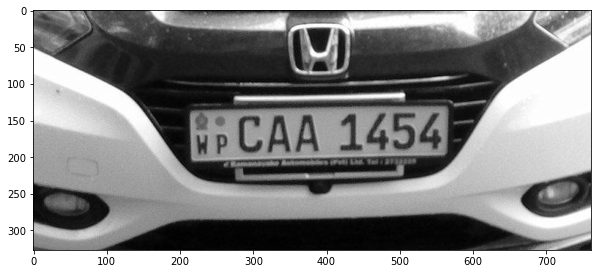

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(test_images[4], cmap='gray')

Histogram equalization to improve contrast

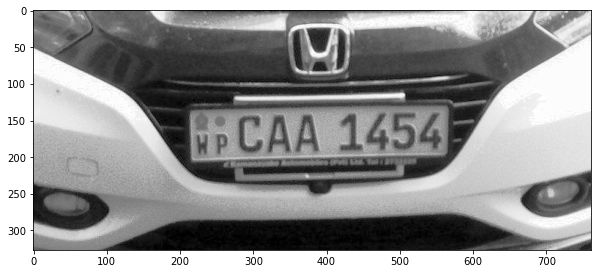

In [ ]:
plt.figure(figsize=(10, 10))
equalized_4 = cv2.equalizeHist(test_images[4])
plt.imshow(equalized_4, cmap='gray')

Remove noise

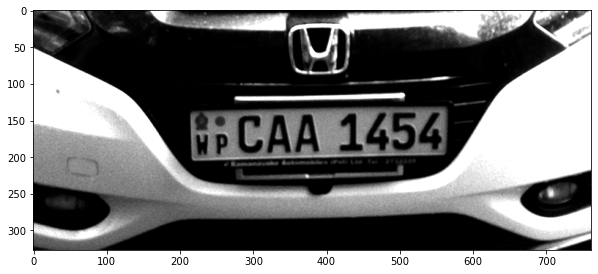

In [ ]:
plt.figure(figsize=(10, 10))
denoised_4 = cv2.bilateralFilter(test_images[4], 3, 75, 75)
denoised_4 = contrast_stretch(denoised_4, 50, 10, 200, 255)
denoised_4 = power_transform(denoised_4, 2)
plt.imshow(denoised_4, cmap='gray')

Blackhat morphological transformation to enhance the text in the white background

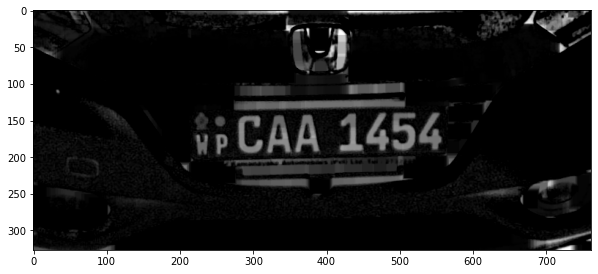

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
blackhat_4 = cv2.morphologyEx(denoised_4, cv2.MORPH_BLACKHAT, kernel)
plt.figure(figsize=(10, 10))
plt.imshow(blackhat_4, cmap='gray')

Thresholding to extract the text

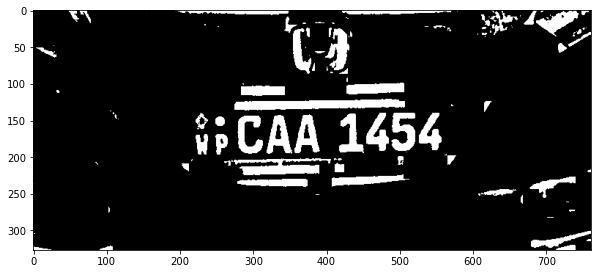

In [ ]:
thresh_4 = cv2.threshold(blackhat_4, 50, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10, 10))
plt.imshow(thresh_4, cmap='gray')

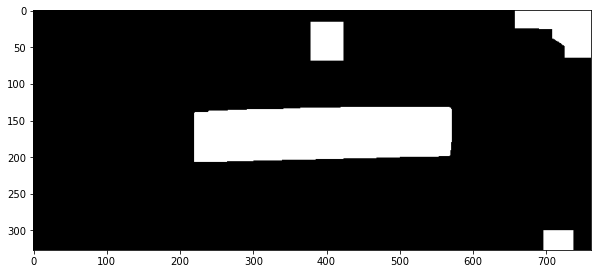

In [ ]:
# Tophat transformation to enhance bright objects in dark background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 15))
tophat_4 = cv2.morphologyEx(denoised_4, cv2.MORPH_TOPHAT, kernel)
# Thresholding the tophat result
top_thresh_4 = cv2.threshold(tophat_4, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Eroding the thresholded image to remove background noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded_4 = cv2.erode(top_thresh_4, kernel, iterations=2)
# Closing the gaps (removing false negatives) in between white pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 3))
top_closing_4 = cv2.morphologyEx(eroded_4, cv2.MORPH_CLOSE, kernel, iterations=6)
# Remove noise (false positives) from foreground
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
top_opening_4 = cv2.morphologyEx(top_closing_4, cv2.MORPH_OPEN, kernel, iterations=8)
# Dilating to expand the foreground closer to the original (expected) size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated_4 = cv2.dilate(top_opening_4, kernel, iterations=2)
plt.figure(figsize=(10, 10))
plt.imshow(dilated_4, cmap='gray')

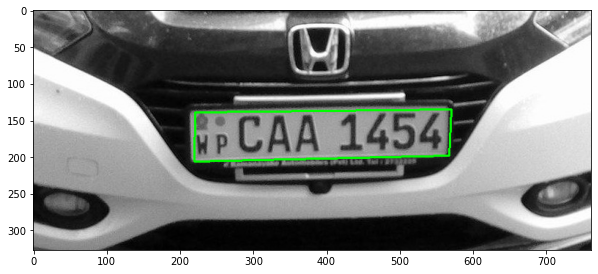

In [ ]:
contours_4, hierarchy = cv2.findContours(dilated_4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_4 = sorted(contours_4, key=cv2.contourArea, reverse = True)[:10]
plate_contour_4 = None
for contour in contours_4:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.06 * perimeter, True).reshape(-1, 2)
    if len(approx) == 4:
        if check_aspect_ratio(contour=approx):
            plate_contour_4 = fix_contour(approx)
            break
    else:
        # Try to find a contour with 4 vertices that has a similar aspect ratio
        approx = find_rect_contour(approx)
        if check_aspect_ratio(contour=approx):
            plate_contour_4 = approx
            break
test_4 = test_images[4].copy()
test_4 = cv2.cvtColor(test_4, cv2.COLOR_GRAY2BGR)
if plate_contour_4 is not None:
    final_4 = cv2.drawContours(test_4, [plate_contour_4], -1, (0, 255, 0), 2)
else:
    final_4 = test_4
plt.figure(figsize=(10, 10))
plt.imshow(final_4)

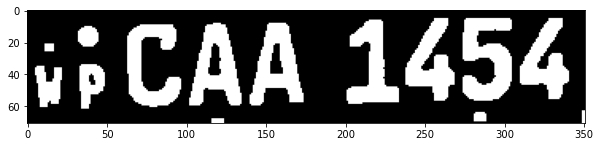

In [ ]:
plate_contour_4 = sorted(plate_contour_4, key=lambda x: x[0])
top_left, top_right, bottom_left, bottom_right = plate_contour_4
if top_left[1] > top_right[1]:
    top_left, top_right = top_right, top_left
if bottom_left[1] > bottom_right[1]:
    bottom_left, bottom_right = bottom_right, bottom_left
width = max(bottom_right[0], bottom_left[0]) - min(top_right[0], top_left[0])
height = max(top_right[1], top_left[1]) - min(bottom_right[1], bottom_left[1])
cropped_4 = thresh_4[top_left[1]:top_left[1] + height, top_left[0]:top_left[0] + width]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
cropped_4 = cv2.morphologyEx(cropped_4, cv2.MORPH_OPEN, kernel, iterations=4)
plt.figure(figsize=(10, 10))
plt.imshow(cropped_4, cmap='gray')

In [ ]:
(num_labels, labels, stats, centroids) = cv2.connectedComponentsWithStats(cropped_4, 4, cv2.CV_32S)
print(f'Found {num_labels} connected components')

Found 15 connected components


Segmenting the license plate number into characters

Average area: 518.0


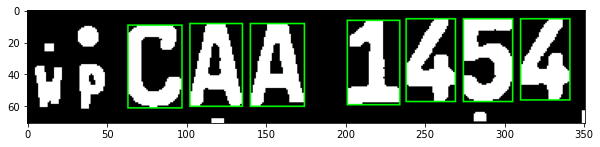

In [ ]:
output = cropped_4.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

num_candidates_4 = []

avg_area = stats[1:, cv2.CC_STAT_AREA].mean()
print(f'Average area: {avg_area}')

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area * 3 > area > avg_area * 0.6 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        num_candidates_4.append((cropped_4[y:y + h, x:x + w], x))
num_candidates_4 = sorted(num_candidates_4, key=lambda x: x[1])
num_candidates_4 = [x[0] for x in num_candidates_4]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [ ]:
for candidate in num_candidates_4:
    res = []
    for img in ground_truth_license:
        res.append(compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_license[res.argmin()])

C
A
A
1
4
5
4


Segmenting the province into characters

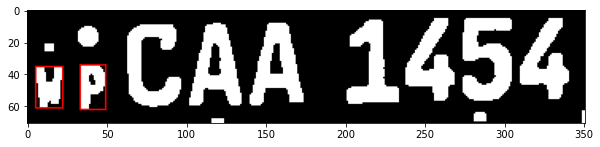

In [ ]:
output = cropped_4.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

province_candidates_4 = []

for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    if avg_area / 3 < area < avg_area / 1.2 and w / h < 1:
        output = cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 1)
        province_candidates_4.append((cropped_4[y:y + h, x:x + w], x))
province_candidates_4 = sorted(province_candidates_4, key=lambda x: x[1])
province_candidates_4 = [x[0] for x in province_candidates_4]
plt.figure(figsize=(10, 10))
plt.imshow(output)

In [ ]:
for candidate in province_candidates_4:
    res = []
    for img, label in zip(ground_truth_province, idx2label_province):
        res.append(cv2.minMaxLoc(cv2.matchTemplate(img, candidate, cv2.TM_SQDIFF))[0] + 6500 * compare_images(candidate, img))
    res = np.array(res)
    print(idx2label_province[res.argmin()])

W
P
